In [195]:
import pandas as pd
from sqlalchemy import create_engine
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import psycopg2
import pandas as pd

DB_CONFIG = {
    'host': 'localhost',
    'port': 5433,  # Ваш порт PostgreSQL!
    'database': 'sports_stats',
    'user': 'postgres',
    'password': '1234'  # Замените на ваш пароль!
}

try:
    conn = psycopg2.connect(**DB_CONFIG)
    print("✅ Подключение к PostgreSQL успешно!")
    
    # Создаем курсор для выполнения SQL
    cur = conn.cursor()
    
    # Проверяем подключение
    cur.execute("SELECT version();")
    db_version = cur.fetchone()
    print(f"Версия PostgreSQL: {db_version[0]}")
    
except Exception as e:
    print(f"❌ Ошибка подключения: {e}")

✅ Подключение к PostgreSQL успешно!
Версия PostgreSQL: PostgreSQL 16.11, compiled by Visual C++ build 1944, 64-bit


In [197]:
import os
import yaml

# Полный путь к конфигу
config_path = r'C:\Users\usman\project_BD\sports-stats-analysis\database\config.yaml'

print(f"📁 Проверяем файл: {config_path}")
print(f"Файл существует: {os.path.exists(config_path)}")

# Читаем конфиг
try:
    with open(config_path, 'r', encoding='utf-8') as f:
        config = yaml.safe_load(f)
    
    print("\n📋 Текущая конфигурация из файла:")
    print("=" * 50)
    print(yaml.dump(config, default_flow_style=False, allow_unicode=True))
    print("=" * 50)
    
except Exception as e:
    print(f"❌ Ошибка чтения: {e}")

📁 Проверяем файл: C:\Users\usman\project_BD\sports-stats-analysis\database\config.yaml
Файл существует: True

📋 Текущая конфигурация из файла:
database:
  database: sports_stats
  host: localhost
  password: '1234'
  port: 5433
  user: postgres
etl:
  batch_size: 1000
  connection_timeout: 30
  create_indexes_first: false
  error_mode: strict
  num_workers: 4
  truncate_before_load: false
field_mappings:
  matches:
    attendance: attendance
    away: away_team_name
    date: match_date
    day: day_of_week
    home: home_team_name
    match_report: match_report_url
    notes: notes
    referee: referee
    score: score
    time: match_time
    venue: venue
    wk: match_week
    xg: home_xg
    xg_1: away_xg
  player_defense:
    90s: ninety_s
    att: challenges_pct
    att_3rd: tackles_att_3rd
    blocks: blocks
    clr: clearances
    def_3rd: tackles_def_3rd
    err: errors
    int: interceptions
    lost: challenges_lost
    mid_3rd: tackles_mid_3rd
    pass: passes_blocked
    s

In [199]:
print("\n🔧 Обновляем конфигурацию...")

# Меняем порт на 5433 и пароль на ваш
config['database']['port'] = 5433  # ⚠️ ВАШ порт!
config['database']['password'] = '1234'  # ⚠️ ВАШ пароль!

# Сохраняем обратно
with open(config_path, 'w', encoding='utf-8') as f:
    yaml.dump(config, f, default_flow_style=False, allow_unicode=True)

print("✅ Конфигурация обновлена!")
print(f"📍 Файл: {config_path}")
print(f"📌 Порт установлен: {config['database']['port']}")
print(f"🔐 Пароль: {config['database']['password']} (замените на свой!)")


🔧 Обновляем конфигурацию...
✅ Конфигурация обновлена!
📍 Файл: C:\Users\usman\project_BD\sports-stats-analysis\database\config.yaml
📌 Порт установлен: 5433
🔐 Пароль: 1234 (замените на свой!)


In [201]:
import socket

print("\n🔌 Пробуем подключиться к PostgreSQL...")

# Настройки из конфига
db_config = config['database']

print(f"Параметры подключения:")
print(f"  Хост: {db_config['host']}")
print(f"  Порт: {db_config['port']}")
print(f"  База: {db_config['database']}")
print(f"  Пользователь: {db_config['user']}")

# Сначала проверим доступность порта
print("\n🔍 Проверка доступности порта...")
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.settimeout(2)
try:
    result = sock.connect_ex((db_config['host'], db_config['port']))
    if result == 0:
        print(f"✅ Порт {db_config['port']} доступен!")
    else:
        print(f"❌ Порт {db_config['port']} недоступен")
        print("Запустите PostgreSQL или проверьте порт")
except Exception as e:
    print(f"❌ Ошибка проверки порта: {e}")
finally:
    sock.close()

# Пробуем подключиться
print("\n🔗 Подключение к базе данных...")
try:
    conn = psycopg2.connect(**db_config)
    cursor = conn.cursor()
    
    print("✅ Подключение успешно!")
    
    # Проверяем версию PostgreSQL
    cursor.execute("SELECT version();")
    version = cursor.fetchone()[0]
    print(f"📊 Версия PostgreSQL: {version.split(',')[0]}")
    
    # Проверяем таблицы
    cursor.execute("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'public'
        ORDER BY table_name
    """)
    
    tables = cursor.fetchall()
    
    if tables:
        print(f"\n📋 Найдено {len(tables)} таблиц:")
        for table in tables:
            print(f"  • {table[0]}")
    else:
        print("\n📭 Таблиц нет. База пустая.")
        
    cursor.close()
    conn.close()
    
except psycopg2.OperationalError as e:
    print(f"❌ Ошибка подключения: {e}")
    print("\nВозможные причины и решения:")
    print("1. ❌ PostgreSQL не запущен")
    print("   ✅ Решение: Запустите PostgreSQL (services.msc)")
    print()
    print(f"2. ❌ Неправильный порт: {db_config['port']}")
    print("   ✅ Решение: Узнайте свой порт в pgAdmin или services.msc")
    print()
    print("3. ❌ Неправильный пароль")
    print(f"   ✅ Решение: Вспомните пароль от пользователя {db_config['user']}")
    print()
    print(f"4. ❌ База '{db_config['database']}' не существует")
    print("   ✅ Решение: Создайте базу командой:")
    print(f"      psql -U postgres -p {db_config['port']} -c \"CREATE DATABASE {db_config['database']};\"")
    
except Exception as e:
    print(f"❌ Неожиданная ошибка: {e}")


🔌 Пробуем подключиться к PostgreSQL...
Параметры подключения:
  Хост: localhost
  Порт: 5433
  База: sports_stats
  Пользователь: postgres

🔍 Проверка доступности порта...
✅ Порт 5433 доступен!

🔗 Подключение к базе данных...
✅ Подключение успешно!
📊 Версия PostgreSQL: PostgreSQL 16.11

📋 Найдено 21 таблиц:
  • leagues
  • matches
  • player_defense_stats
  • player_keeper_adv_stats
  • player_keeper_stats
  • player_misc_stats
  • player_passing_stats
  • player_passing_types_stats
  • player_possession_stats
  • player_shooting_stats
  • player_standard_stats
  • player_team_seasons
  • players
  • seasons
  • standings
  • team_season_stats
  • teams
  • v_head_to_head
  • v_home_away_win_rate
  • v_team_form_by_month
  • v_team_style_metrics


In [203]:
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

db_config = config['database']

# Создаем подключение
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

print("🔍 ИЗУЧАЕМ ДОСТУПНЫЕ МЕТРИКИ ДЛЯ КЛАСТЕРИЗАЦИИ")
print("=" * 80)

🔍 ИЗУЧАЕМ ДОСТУПНЫЕ МЕТРИКИ ДЛЯ КЛАСТЕРИЗАЦИИ


In [205]:
# 1. Посмотрим структуру таблицы team_season_stats
print("\n📋 СТРУКТУРА team_season_stats:")
team_stats_columns = pd.read_sql_query("""
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_name = 'team_season_stats' 
    AND table_schema = 'public'
    ORDER BY ordinal_position
""", engine)
print(team_stats_columns.to_string(index=False))


📋 СТРУКТУРА team_season_stats:
                     column_name                   data_type
                  team_season_id                     integer
                       league_id                     integer
                       season_id                     integer
                         team_id                     integer
                    players_used                     integer
                         avg_age                     numeric
                  possession_pct                     numeric
                  matches_played                     integer
                          starts                     integer
                         minutes                     integer
                        ninety_s                     numeric
                           goals                     integer
                         assists                     integer
                   goals_assists                     integer
               goals_non_penalty                     

In [207]:
print("\n📊 ПЕРВУЮ 1 ЗАПИСЬ:")
team_stats_sample = pd.read_sql_query("SELECT * FROM team_season_stats LIMIT 1", engine)
print(team_stats_sample.to_string(index=False))


📊 ПЕРВУЮ 1 ЗАПИСЬ:
 team_season_id  league_id  season_id  team_id  players_used  avg_age  possession_pct  matches_played  starts  minutes  ninety_s  goals  assists  goals_assists  goals_non_penalty  penalties  penalty_attempts   xg  npxg  xag  npxg_xag  yellow_cards  red_cards  progressive_carries  progressive_passes  goals_per_90  assists_per_90  goals_assists_per_90  goals_non_penalty_per_90  goals_assists_non_penalty_per_90  xg_per_90  xag_per_90  xg_xag_per_90  npxg_per_90  npxg_xag_per_90                 created_at
              1         11          1       22            28     27.5            49.8              23     253     2070      23.0     19       11             30                 17          2                 2 19.3  17.7 10.5      28.2            74          3                  296                 794          0.83            0.48                   1.3                      0.74                              1.22       0.84        0.46            1.3         0.77           

In [209]:
print("\n🧮 ЧИСЛОВЫЕ КОЛОНКИ ДЛЯ АНАЛИЗА:")
numeric_columns_query = """
SELECT column_name, data_type 
FROM information_schema.columns 
WHERE table_name = 'team_season_stats' 
AND table_schema = 'public'
AND data_type IN ('integer', 'numeric', 'double precision', 'real', 'bigint')
ORDER BY column_name
"""
numeric_columns = pd.read_sql_query(numeric_columns_query, engine)
print(numeric_columns.to_string(index=False))


🧮 ЧИСЛОВЫЕ КОЛОНКИ ДЛЯ АНАЛИЗА:
                     column_name data_type
                         assists   integer
                  assists_per_90   numeric
                         avg_age   numeric
                           goals   integer
                   goals_assists   integer
goals_assists_non_penalty_per_90   numeric
            goals_assists_per_90   numeric
               goals_non_penalty   integer
        goals_non_penalty_per_90   numeric
                    goals_per_90   numeric
                       league_id   integer
                  matches_played   integer
                         minutes   integer
                        ninety_s   numeric
                            npxg   numeric
                     npxg_per_90   numeric
                        npxg_xag   numeric
                 npxg_xag_per_90   numeric
                       penalties   integer
                penalty_attempts   integer
                    players_used   integer
                  pos

In [211]:
print("\n" + "=" * 80)
print("📥 ЗАГРУЖАЕМ ДАННЫЕ ДЛЯ АНАЛИЗА")
print("=" * 80)

query_corrected = """
SELECT 
    tss.*,
    t.team_name,
    l.league_name,
    s.season_code as season_name
FROM team_season_stats tss
LEFT JOIN teams t ON tss.team_id = t.team_id
LEFT JOIN leagues l ON tss.league_id = l.league_id
LEFT JOIN seasons s ON tss.season_id = s.season_id
WHERE tss.matches_played > 10  -- Исключаем команды с малым количеством матчей
"""

team_data = pd.read_sql_query(query_corrected, engine)
print(f"📊 Загружено {len(team_data)} записей")
print(f"📈 Уникальных сезонов: {team_data['season_id'].nunique()}")
print(f"🏆 Уникальных лиг: {team_data['league_id'].nunique()}")
print(f"👥 Уникальных команд: {team_data['team_id'].nunique()}")

# Посмотрим первые строки
print("\n📋 ПЕРВЫЕ 5 ЗАПИСЕЙ:")
print(team_data.head().to_string(index=False))


📥 ЗАГРУЖАЕМ ДАННЫЕ ДЛЯ АНАЛИЗА
📊 Загружено 1837 записей
📈 Уникальных сезонов: 12
🏆 Уникальных лиг: 15
👥 Уникальных команд: 407

📋 ПЕРВЫЕ 5 ЗАПИСЕЙ:
 team_season_id  league_id  season_id  team_id  players_used  avg_age  possession_pct  matches_played  starts  minutes  ninety_s  goals  assists  goals_assists  goals_non_penalty  penalties  penalty_attempts   xg  npxg  xag  npxg_xag  yellow_cards  red_cards  progressive_carries  progressive_passes  goals_per_90  assists_per_90  goals_assists_per_90  goals_non_penalty_per_90  goals_assists_non_penalty_per_90  xg_per_90  xag_per_90  xg_xag_per_90  npxg_per_90  npxg_xag_per_90                 created_at    team_name      league_name season_name
              1         11          1       22            28     27.5            49.8              23     253     2070      23.0     19       11             30                 17          2                 2 19.3  17.7 10.5      28.2            74          3                296.0               794.0   

In [213]:
print("\n" + "=" * 80)
print("🔍 ИЗУЧАЕМ СТРУКТУРУ ДАННЫХ team_season_stats")
print("=" * 80)

# Получаем все колонки таблицы team_season_stats
columns_query = """
SELECT column_name, data_type 
FROM information_schema.columns 
WHERE table_name = 'team_season_stats' 
AND table_schema = 'public'
ORDER BY ordinal_position
"""

columns_info = pd.read_sql_query(columns_query, engine)
print("📋 ВСЕ КОЛОНКИ В team_season_stats:")
print(columns_info.to_string(index=False))


🔍 ИЗУЧАЕМ СТРУКТУРУ ДАННЫХ team_season_stats
📋 ВСЕ КОЛОНКИ В team_season_stats:
                     column_name                   data_type
                  team_season_id                     integer
                       league_id                     integer
                       season_id                     integer
                         team_id                     integer
                    players_used                     integer
                         avg_age                     numeric
                  possession_pct                     numeric
                  matches_played                     integer
                          starts                     integer
                         minutes                     integer
                        ninety_s                     numeric
                           goals                     integer
                         assists                     integer
                   goals_assists                     integer
    

In [215]:
print("\n📊 СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ:")
numeric_cols = team_data.select_dtypes(include=[np.number]).columns.tolist()
print(f"Найдено {len(numeric_cols)} числовых колонок")


📊 СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ:
Найдено 35 числовых колонок


In [217]:
print("\n" + "=" * 80)
print("🎯 ВЫБИРАЕМ МЕТРИКИ ДЛЯ АНАЛИЗА СТИЛЯ ИГРЫ")
print("=" * 80)

# Группируем метрики по аспектам игры
style_metrics = {
    'Атакующий потенциал': [
        'goals_per_90',           # Голы за 90 минут
        'xg_per_90',              # Ожидаемые голы
        'npxg_per_90',            # Ожидаемые голы без пенальти
        'goals_non_penalty_per_90', # Голы без пенальти
    ],
    
    'Креативность и созидание': [
        'assists_per_90',         # Голевые передачи
        'xag_per_90',             # Ожидаемые голевые передачи
        'xg_xag_per_90',          # Ожидаемые голы + передачи
        'npxg_xag_per_90',        # npxg + xag
        'progressive_passes',     # Прогрессивные передачи
    ],
    
    'Контроль мяча и владение': [
        'possession_pct',         # Процент владения мячом
        'progressive_carries',    # Прогрессивные проносы
    ],
    
    'Агрессивность и физика': [
        'yellow_cards',           # Желтые карточки
        'red_cards',              # Красные карточки
    ],
    
    'Возрастной состав': [
        'avg_age',                # Средний возраст
        'players_used',           # Количество использованных игроков
    ],
    
    'Базовая результативность': [
        'goals',                  # Всего голов
        'assists',                # Всего передач
        'goals_assists',          # Голы+передачи
    ]
}

# Покажем выбранные метрики
print("📊 ВЫБРАННЫЕ МЕТРИКИ ПО ГРУППАМ:")
for group, metrics in style_metrics.items():
    print(f"\n{group}:")
    for metric in metrics:
        if metric in team_data.columns:
            print(f"  ✓ {metric}")
        else:
            print(f"  ✗ {metric} (не найдено)")



🎯 ВЫБИРАЕМ МЕТРИКИ ДЛЯ АНАЛИЗА СТИЛЯ ИГРЫ
📊 ВЫБРАННЫЕ МЕТРИКИ ПО ГРУППАМ:

Атакующий потенциал:
  ✓ goals_per_90
  ✓ xg_per_90
  ✓ npxg_per_90
  ✓ goals_non_penalty_per_90

Креативность и созидание:
  ✓ assists_per_90
  ✓ xag_per_90
  ✓ xg_xag_per_90
  ✓ npxg_xag_per_90
  ✓ progressive_passes

Контроль мяча и владение:
  ✓ possession_pct
  ✓ progressive_carries

Агрессивность и физика:
  ✓ yellow_cards
  ✓ red_cards

Возрастной состав:
  ✓ avg_age
  ✓ players_used

Базовая результативность:
  ✓ goals
  ✓ assists
  ✓ goals_assists


In [219]:
# Создаем список доступных метрик
available_style_metrics = []
for metrics_list in style_metrics.values():
    for metric in metrics_list:
        if metric in team_data.columns and metric not in available_style_metrics:
            available_style_metrics.append(metric)

print(f"\n✅ Доступно для анализа: {len(available_style_metrics)} метрик")


✅ Доступно для анализа: 18 метрик


In [221]:
print("\n" + "=" * 80)
print("🔧 ПОДГОТОВКА ДАННЫХ ДЛЯ КЛАСТЕРИЗАЦИИ")
print("=" * 80)

# Добавляем season_name в данные (используем season_code)
team_data['season_name'] = team_data['season_name']

# Создаем DataFrame для кластеризации
clustering_data = team_data[['team_id', 'team_name', 'season_id', 'season_name', 'league_name'] + available_style_metrics].copy()

# Проверяем наличие данных
print(f"📊 Исходное количество записей: {len(clustering_data)}")


🔧 ПОДГОТОВКА ДАННЫХ ДЛЯ КЛАСТЕРИЗАЦИИ
📊 Исходное количество записей: 1837


In [223]:
# Обрабатываем пропущенные значения
# Для метрик на 90 минут заполняем 0 если minutes > 0
per_90_metrics = [m for m in available_style_metrics if '_per_90' in m or '_per_90' in m]

for metric in per_90_metrics:
    # Создаем базовую метрику без _per_90
    base_metric = metric.replace('_per_90', '')
    if base_metric in clustering_data.columns:
        # Если есть minutes, рассчитываем per_90
        if 'minutes' in clustering_data.columns:
            mask = (clustering_data['minutes'] > 0) & (clustering_data[metric].isna())
            clustering_data.loc[mask, metric] = clustering_data.loc[mask, base_metric] / clustering_data.loc[mask, 'minutes'] * 90

# Удаляем строки с пропущенными значениями
clustering_data_clean = clustering_data.dropna(subset=available_style_metrics)

print(f"📈 После очистки: {len(clustering_data_clean)} записей")

📈 После очистки: 1506 записей


In [225]:
# Стандартизируем данные
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_data_clean[available_style_metrics])

print("✅ Данные стандартизированы")
print(f"📐 Размерность данных: {X_scaled.shape}")
print(f"🏷️ Метки кластеризации будут сохранены для {len(clustering_data_clean)} команд")

✅ Данные стандартизированы
📐 Размерность данных: (1506, 18)
🏷️ Метки кластеризации будут сохранены для 1506 команд



📈 ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ
                              


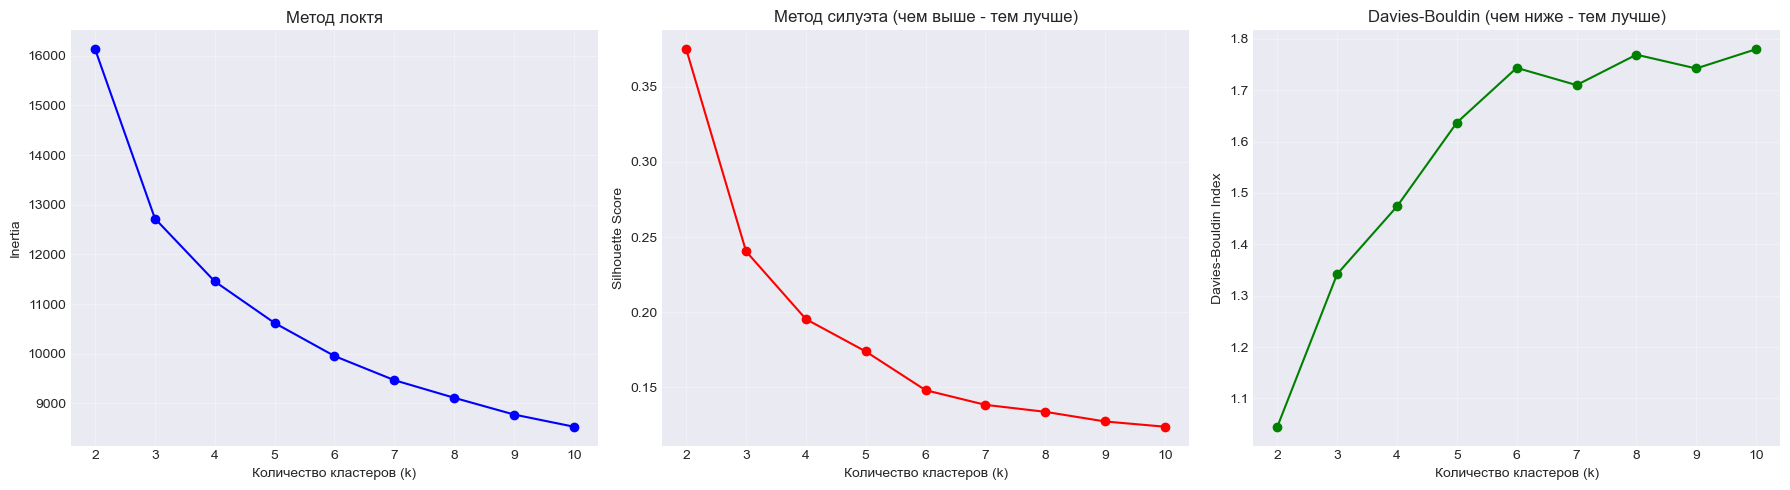


📊 РЕЗУЛЬТАТЫ:
  Метод силуэта: оптимально k = 2 (score = 0.375)
  Davies-Bouldin: оптимально k = 2 (score = 1.045)


In [227]:
print("\n" + "=" * 80)
print("📈 ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ")
print("=" * 80)

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

k_range = range(2, 11)
inertia = []
silhouette_scores = []
davies_bouldin_scores = []

for k in k_range:
    print(f"  Анализируем k={k}...", end='\r')
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    
    if len(X_scaled) > k:
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
        davies_bouldin_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))
    else:
        silhouette_scores.append(0)
        davies_bouldin_scores.append(10)  # Максимально плохой score

print(" " * 30)  # Очистка строки прогресса

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Метод локтя
axes[0].plot(k_range, inertia, 'bo-')
axes[0].set_xlabel('Количество кластеров (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Метод локтя')
axes[0].grid(True, alpha=0.3)

# Метод силуэта
axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Количество кластеров (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Метод силуэта (чем выше - тем лучше)')
axes[1].grid(True, alpha=0.3)

# Davies-Bouldin Index
axes[2].plot(k_range, davies_bouldin_scores, 'go-')
axes[2].set_xlabel('Количество кластеров (k)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin (чем ниже - тем лучше)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выбираем оптимальное k на основе silhouette score
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_davies = k_range[np.argmin(davies_bouldin_scores)]

print(f"\n📊 РЕЗУЛЬТАТЫ:")
print(f"  Метод силуэта: оптимально k = {optimal_k_silhouette} (score = {max(silhouette_scores):.3f})")
print(f"  Davies-Bouldin: оптимально k = {optimal_k_davies} (score = {min(davies_bouldin_scores):.3f})")

In [229]:
# Выбираем оптимальное k (предпочтение silhouette)
optimal_k = optimal_k_silhouette
print(f"\n🎯 ВЫБРАНО: k = {optimal_k}")


🎯 ВЫБРАНО: k = 2


In [231]:
print("\n" + "=" * 80)
print("🔍 АНАЛИЗ ПРОБЛЕМЫ: ПОЧЕМУ ВСЕГО 2 КЛАСТЕРА?")
print("=" * 80)

# Проверим распределение данных
print("📊 РАСПРЕДЕЛЕНИЕ ДАННЫХ ПО СЕЗОНАМ:")
season_counts = clustering_data_clean['season_name'].value_counts()
print(season_counts)

print("\n📈 СТАТИСТИКА КЛЮЧЕВЫХ МЕТРИК:")
print(clustering_data_clean[available_style_metrics].describe().round(2))

# Проверим корреляцию между метриками
print("\n🔗 КОРРЕЛЯЦИЯ МЕЖДУ МЕТРИКАМИ (первые 5x5):")
corr_matrix = clustering_data_clean[available_style_metrics].corr()
print(corr_matrix.iloc[:5, :5].round(2))

# Проверим наличие выбросов
print("\n📊 ПРОВЕРКА НА ВЫБРОСЫ (z-score > 3):")
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

outliers_count = {}
for metric in available_style_metrics[:10]:  # Проверим первые 10 метрик
    z_scores = np.abs(stats.zscore(clustering_data_clean[metric].dropna()))
    outliers = np.sum(z_scores > 3)
    if outliers > 0:
        outliers_count[metric] = outliers

if outliers_count:
    print("Найдены выбросы:")
    for metric, count in outliers_count.items():
        print(f"  {metric}: {count} выбросов ({(count/len(clustering_data_clean))*100:.1f}%)")
else:
    print("Выбросов не найдено (z-score < 3 для всех метрик)")


🔍 АНАЛИЗ ПРОБЛЕМЫ: ПОЧЕМУ ВСЕГО 2 КЛАСТЕРА?
📊 РАСПРЕДЕЛЕНИЕ ДАННЫХ ПО СЕЗОНАМ:
season_name
2019-2020    201
2020-2021    176
2021-2022    176
2022-2023    176
2023-2024    174
2024-2025    174
2025          80
2023          77
2024          77
2022          76
2021          73
2020          46
Name: count, dtype: int64

📈 СТАТИСТИКА КЛЮЧЕВЫХ МЕТРИК:
       goals_per_90  xg_per_90  npxg_per_90  goals_non_penalty_per_90  \
count       1506.00    1506.00      1506.00                   1506.00   
mean           1.30       1.33         1.21                      1.18   
std            0.41       0.32         0.30                      0.39   
min            0.48       0.69         0.65                      0.41   
25%            1.00       1.10         0.99                      0.91   
50%            1.24       1.27         1.16                      1.12   
75%            1.53       1.48         1.35                      1.39   
max            3.18       2.97         2.88                    


🚀 ИСПРАВЛЕННЫЙ ПОДХОД: ВЫБИРАЕМ РАЗНООБРАЗНЫЕ МЕТРИКИ
✅ Выбрано разнообразных метрик: 8

🔗 КОРРЕЛЯЦИЯ ВЫБРАННЫХ МЕТРИК:
                    goals_per_90  assists_per_90  possession_pct  \
goals_per_90                1.00            0.96            0.65   
assists_per_90              0.96            1.00            0.63   
possession_pct              0.65            0.63            1.00   
yellow_cards               -0.28           -0.28           -0.18   
progressive_passes          0.64            0.62            0.72   
avg_age                    -0.08           -0.09           -0.07   
players_used               -0.27           -0.26           -0.09   
attack_efficiency           0.64            0.61            0.25   

                    yellow_cards  progressive_passes  avg_age  players_used  \
goals_per_90               -0.28                0.64    -0.08         -0.27   
assists_per_90             -0.28                0.62    -0.09         -0.26   
possession_pct             -0

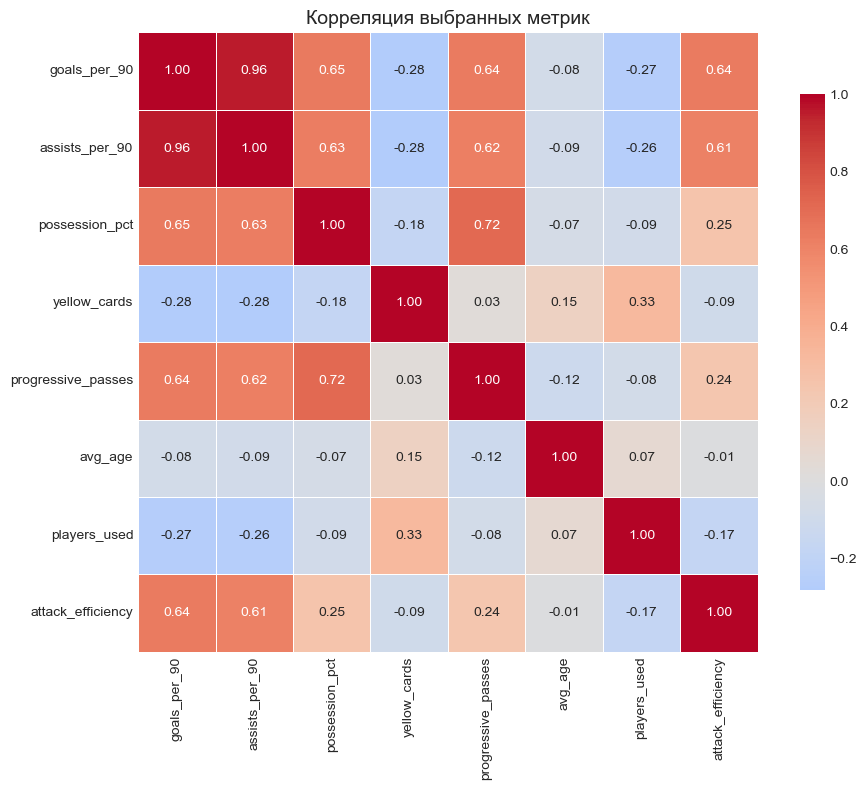

In [233]:
print("\n" + "=" * 80)
print("🚀 ИСПРАВЛЕННЫЙ ПОДХОД: ВЫБИРАЕМ РАЗНООБРАЗНЫЕ МЕТРИКИ")
print("=" * 80)

# Выбираем метрики с низкой корреляцией друг с другом
diverse_metrics = [
    # 1. Атакующий потенциал (выбираем одну)
    'goals_per_90',           # Реальные голы
    
    # 2. Креативность (выбираем одну)
    'assists_per_90',         # Голевые передачи
    
    # 3. Владение мячом
    'possession_pct',         # Процент владения
    
    # 4. Физическая игра/агрессивность
    'yellow_cards',           # Желтые карточки
    
    # 5. Прогрессивные действия
    'progressive_passes',     # Прогрессивные передачи
    
    # 6. Возрастной состав
    'avg_age',                # Средний возраст
    
    # 7. Использование состава
    'players_used',           # Количество использованных игроков
    
    # 8. Эффективность в атаке (отношение реальных к ожидаемым голам)
    # Рассчитаем новую метрику: эффективность атаки
]

# Рассчитываем новую метрику: эффективность атаки (реальные голы / ожидаемые голы)
clustering_data_clean['attack_efficiency'] = clustering_data_clean['goals_per_90'] / clustering_data_clean['xg_per_90'].clip(lower=0.1)
diverse_metrics.append('attack_efficiency')

# Проверяем доступность
available_diverse = [m for m in diverse_metrics if m in clustering_data_clean.columns]
print(f"✅ Выбрано разнообразных метрик: {len(available_diverse)}")

# Проверяем корреляцию новых метрик
print("\n🔗 КОРРЕЛЯЦИЯ ВЫБРАННЫХ МЕТРИК:")
corr_diverse = clustering_data_clean[available_diverse].corr()
print(corr_diverse.round(2))

# Визуализируем корреляционную матрицу
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(corr_diverse, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Корреляция выбранных метрик', fontsize=14)
plt.tight_layout()
plt.show()

In [235]:
print("\n" + "=" * 80)
print("🔍 ПРОВЕРЯЕМ ДОСТУПНЫЕ КОЛОНКИ В clustering_data_clean")
print("=" * 80)

# Посмотрим все колонки
print("📋 ВСЕ КОЛОНКИ В ДАННЫХ:")
columns_list = list(clustering_data_clean.columns)
for i, col in enumerate(columns_list[:30]):  # Покажем первые 30
    print(f"  {i+1:2}. {col}")
if len(columns_list) > 30:
    print(f"  ... и еще {len(columns_list) - 30} колонок")

# Ищем колонки с играми/матчами
print("\n🔍 ИЩЕМ КОЛОНКИ С ИНФОРМАЦИЕЙ О МАТЧАХ:")
match_related = [col for col in columns_list if 'match' in col.lower() or 'game' in col.lower() or 'played' in col.lower()]
for col in match_related:
    print(f"  • {col}: {clustering_data_clean[col].dtype}")


🔍 ПРОВЕРЯЕМ ДОСТУПНЫЕ КОЛОНКИ В clustering_data_clean
📋 ВСЕ КОЛОНКИ В ДАННЫХ:
   1. team_id
   2. team_name
   3. season_id
   4. season_name
   5. league_name
   6. goals_per_90
   7. xg_per_90
   8. npxg_per_90
   9. goals_non_penalty_per_90
  10. assists_per_90
  11. xag_per_90
  12. xg_xag_per_90
  13. npxg_xag_per_90
  14. progressive_passes
  15. possession_pct
  16. progressive_carries
  17. yellow_cards
  18. red_cards
  19. avg_age
  20. players_used
  21. goals
  22. assists
  23. goals_assists
  24. attack_efficiency

🔍 ИЩЕМ КОЛОНКИ С ИНФОРМАЦИЕЙ О МАТЧАХ:


In [237]:
print("\n" + "=" * 80)
print("🚀 ПРОДОЛЖАЕМ С ФИНАЛЬНЫМ НАБОРОМ МЕТРИК")
print("=" * 80)

# Так как нет matches_played, используем yellow_cards как есть
# И создадим новую метрику: интенсивность атаки (отношение прогрессивных действий к голам)

final_metrics_corrected = [
    # 1. Атакующий потенциал
    'goals_per_90',           # Реальные голы за 90 минут
    
    # 2. Владение мячом и контроль
    'possession_pct',         # Процент владения мячом
    
    # 3. Физическая игра (оставляем как есть)
    'yellow_cards',           # Желтые карточки (абсолютное значение)
    
    # 4. Креативность и прогрессивность
    'progressive_passes',     # Прогрессивные передачи
    
    # 5. Возрастной состав
    'avg_age',                # Средний возраст команды
    
    # 6. Широта использования состава
    'players_used',           # Количество использованных игроков
    
    # 7. Эффективность атаки
    'attack_efficiency',      # Отношение реальных голов к ожидаемым
    
    # 8. Разнообразие атаки (уже создана)
    'attack_diversity',       # Отношение прогрессивных передач к голам
]

# Проверяем доступность
available_final_corrected = [m for m in final_metrics_corrected if m in clustering_data_clean.columns]
print(f"✅ Финальный набор метрик ({len(available_final_corrected)}):")
for i, metric in enumerate(available_final_corrected):
    print(f"  {i+1:2}. {metric}")

# Проверяем корреляцию
print("\n🔗 КОРРЕЛЯЦИЯ ФИНАЛЬНЫХ МЕТРИК:")
corr_final_corrected = clustering_data_clean[available_final_corrected].corr()
print(corr_final_corrected.round(2))


🚀 ПРОДОЛЖАЕМ С ФИНАЛЬНЫМ НАБОРОМ МЕТРИК
✅ Финальный набор метрик (7):
   1. goals_per_90
   2. possession_pct
   3. yellow_cards
   4. progressive_passes
   5. avg_age
   6. players_used
   7. attack_efficiency

🔗 КОРРЕЛЯЦИЯ ФИНАЛЬНЫХ МЕТРИК:
                    goals_per_90  possession_pct  yellow_cards  \
goals_per_90                1.00            0.65         -0.28   
possession_pct              0.65            1.00         -0.18   
yellow_cards               -0.28           -0.18          1.00   
progressive_passes          0.64            0.72          0.03   
avg_age                    -0.08           -0.07          0.15   
players_used               -0.27           -0.09          0.33   
attack_efficiency           0.64            0.25         -0.09   

                    progressive_passes  avg_age  players_used  \
goals_per_90                      0.64    -0.08         -0.27   
possession_pct                    0.72    -0.07         -0.09   
yellow_cards                    


📊 ЗАПУСКАЕМ ФИНАЛЬНУЮ КЛАСТЕРИЗАЦИЮ
🔍 Определяем оптимальное количество кластеров...


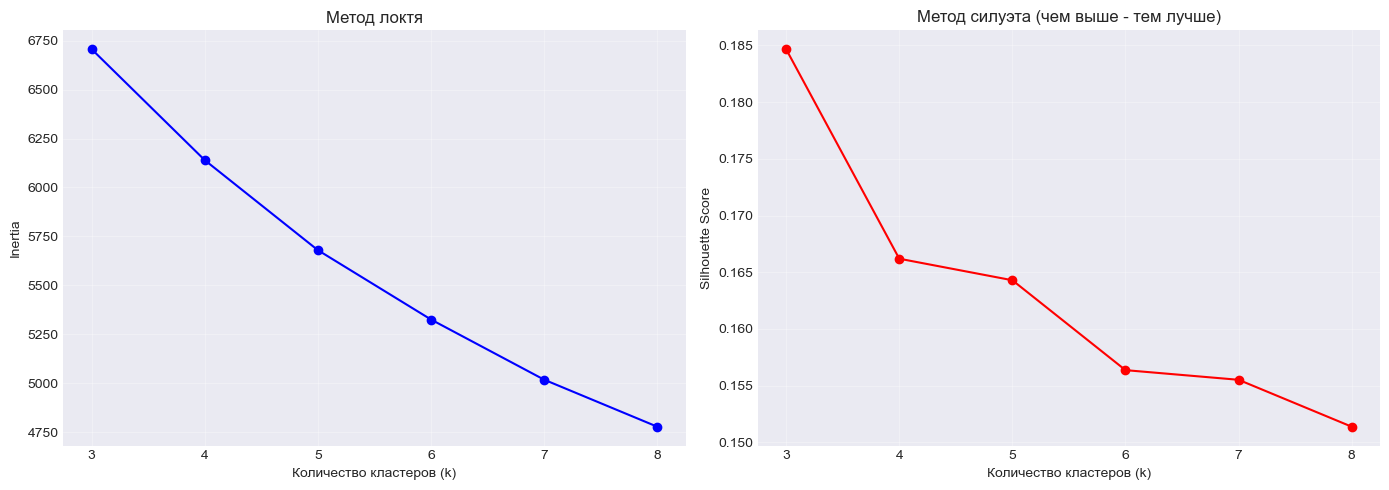


🎯 Оптимальное количество кластеров: 3
📊 Silhouette Score: 0.185

📊 РАСПРЕДЕЛЕНИЕ ПО КЛАСТЕРАМ:
  Кластер 0:  433 команд ( 28.8%)
  Кластер 1:  516 команд ( 34.3%)
  Кластер 2:  557 команд ( 37.0%)


In [239]:
print("\n" + "=" * 80)
print("📊 ЗАПУСКАЕМ ФИНАЛЬНУЮ КЛАСТЕРИЗАЦИЮ")
print("=" * 80)

from scipy.stats import mstats

def winsorize_column(series, limits=(0.05, 0.05)):
    """Винзоризация - ограничение выбросов"""
    return pd.Series(mstats.winsorize(series, limits=limits), index=series.index)


# Подготовка данных
X_final_corrected = clustering_data_clean[available_final_corrected].copy()

# Винзоризация (ограничение выбросов)
for col in X_final_corrected.columns:
    if X_final_corrected[col].dtype in [np.float64, np.int64]:
        X_final_corrected[col] = winsorize_column(X_final_corrected[col], limits=(0.05, 0.05))

# Стандартизация
scaler_final_corrected = StandardScaler()
X_scaled_final_corrected = scaler_final_corrected.fit_transform(X_final_corrected)

# Определяем оптимальное количество кластеров
print("🔍 Определяем оптимальное количество кластеров...")

k_range = range(3, 9)
inertia_values = []
silhouette_values = []

for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=15)
    kmeans_test.fit(X_scaled_final_corrected)
    inertia_values.append(kmeans_test.inertia_)
    
    if len(X_scaled_final_corrected) > k:
        silhouette_values.append(silhouette_score(X_scaled_final_corrected, kmeans_test.labels_))
    else:
        silhouette_values.append(0)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertia_values, 'bo-')
axes[0].set_xlabel('Количество кластеров (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Метод локтя')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_values, 'ro-')
axes[1].set_xlabel('Количество кластеров (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Метод силуэта (чем выше - тем лучше)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выбираем оптимальное k
optimal_k = k_range[np.argmax(silhouette_values)]
print(f"\n🎯 Оптимальное количество кластеров: {optimal_k}")
print(f"📊 Silhouette Score: {max(silhouette_values):.3f}")

# Выполняем кластеризацию
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clustering_data_clean['cluster'] = kmeans_final.fit_predict(X_scaled_final_corrected)

print(f"\n📊 РАСПРЕДЕЛЕНИЕ ПО КЛАСТЕРАМ:")
cluster_dist = clustering_data_clean['cluster'].value_counts().sort_index()
for cluster, count in cluster_dist.items():
    percentage = count / len(clustering_data_clean) * 100
    print(f"  Кластер {cluster}: {count:4d} команд ({percentage:5.1f}%)")

In [241]:
print("\n" + "=" * 80)
print("🎯 АНАЛИЗ ТРЕХ КЛАСТЕРОВ СТИЛЕЙ ИГРЫ")
print("=" * 80)

# Анализируем центры кластеров более подробно
centers_original = pd.DataFrame(
    scaler_final_corrected.inverse_transform(kmeans_final.cluster_centers_),
    columns=available_final_corrected,
    index=['Кластер 0', 'Кластер 1', 'Кластер 2']
)
centers_original['attack_diversity'] = centers_original['progressive_passes'] / centers_original['goals_per_90'].clip(lower=0.5)

print("📊 ДЕТАЛЬНЫЕ ХАРАКТЕРИСТИКИ КЛАСТЕРОВ:")
display_metrics = [
    'goals_per_90',           # Атака
    'possession_pct',         # Контроль
    'yellow_cards',           # Агрессивность  
    'progressive_passes',     # Креативность
    'avg_age',                # Возраст
    'players_used',           # Широта состава
    'attack_efficiency',      # Эффективность
    'attack_diversity'        # Разнообразие
]
print(centers_original[display_metrics].round(2))

# Определяем стили для каждого кластера
print("\n🏷️ ОПРЕДЕЛЯЕМ СТИЛИ ИГРЫ:")

# Анализируем каждый кластер
cluster_styles = {}
for cluster_idx in range(3):
    profile = centers_original.loc[f'Кластер {cluster_idx}']
    
    goals = profile['goals_per_90']
    possession = profile['possession_pct']
    yellow = profile['yellow_cards']
    progressive = profile['progressive_passes']
    age = profile['avg_age']
    efficiency = profile['attack_efficiency']
    
    print(f"\n🔍 КЛАСТЕР {cluster_idx}:")
    print(f"  • Голы/90: {goals:.2f}")
    print(f"  • Владение: {possession:.1f}%")
    print(f"  • Желтые карточки: {yellow:.0f}")
    print(f"  • Эффективность атаки: {efficiency:.2f}")
    
    # Определяем стиль
    if goals > 1.4:
        if possession > 51:
            style = "Доминирующие атакующие"
        else:
            style = "Эффективные контратакующие"
    elif goals < 1.2:
        if possession > 50:
            style = "Контролирующие оборонительные"
        elif yellow > 75:
            style = "Агрессивные оборонительные"
        else:
            style = "Сбалансированные оборонительные"
    else:
        if efficiency > 1.0:
            style = "Эффективные сбалансированные"
        else:
            style = "Стандартные"
    
    cluster_styles[cluster_idx] = style
    print(f"  🎯 СТИЛЬ: {style}")

# Присваиваем стили данным
clustering_data_clean['playing_style'] = clustering_data_clean['cluster'].map(cluster_styles)

print(f"\n✅ Стили определены и присвоены командам")


🎯 АНАЛИЗ ТРЕХ КЛАСТЕРОВ СТИЛЕЙ ИГРЫ
📊 ДЕТАЛЬНЫЕ ХАРАКТЕРИСТИКИ КЛАСТЕРОВ:
           goals_per_90  possession_pct  yellow_cards  progressive_passes  \
Кластер 0          1.71           55.89         72.21             1630.46   
Кластер 1          1.02           47.46         87.74             1203.71   
Кластер 2          1.22           47.69         64.26             1138.85   

           avg_age  players_used  attack_efficiency  attack_diversity  
Кластер 0    26.51         29.53               1.06            955.05  
Кластер 1    26.80         33.83               0.90           1177.96  
Кластер 2    26.47         28.31               0.97            932.88  

🏷️ ОПРЕДЕЛЯЕМ СТИЛИ ИГРЫ:

🔍 КЛАСТЕР 0:
  • Голы/90: 1.71
  • Владение: 55.9%
  • Желтые карточки: 72
  • Эффективность атаки: 1.06
  🎯 СТИЛЬ: Доминирующие атакующие

🔍 КЛАСТЕР 1:
  • Голы/90: 1.02
  • Владение: 47.5%
  • Желтые карточки: 88
  • Эффективность атаки: 0.90
  🎯 СТИЛЬ: Агрессивные оборонительные

🔍 КЛАСТЕР 2:
  •


📊 ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ


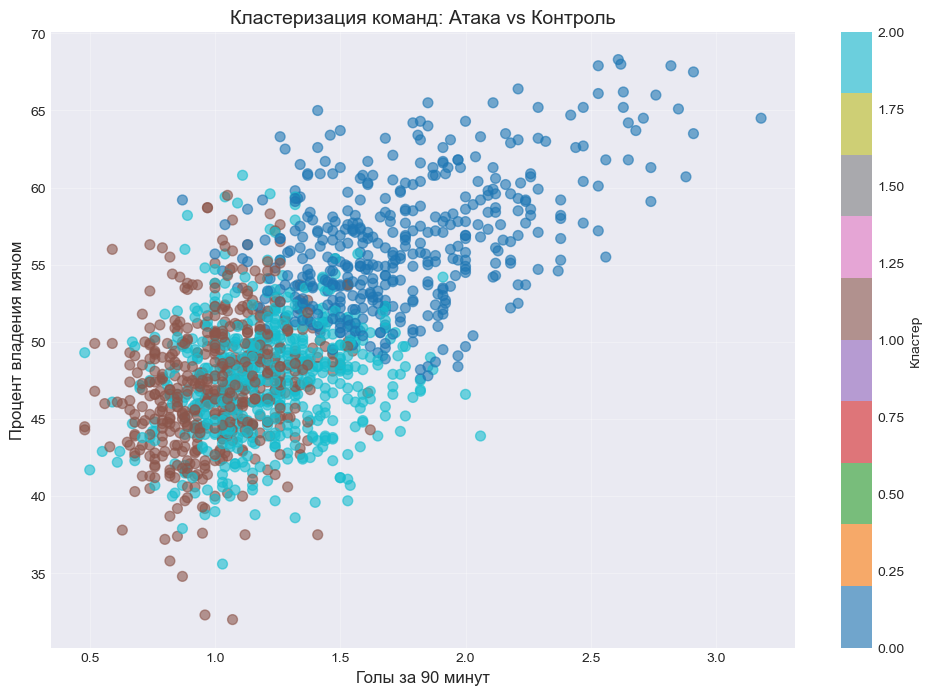

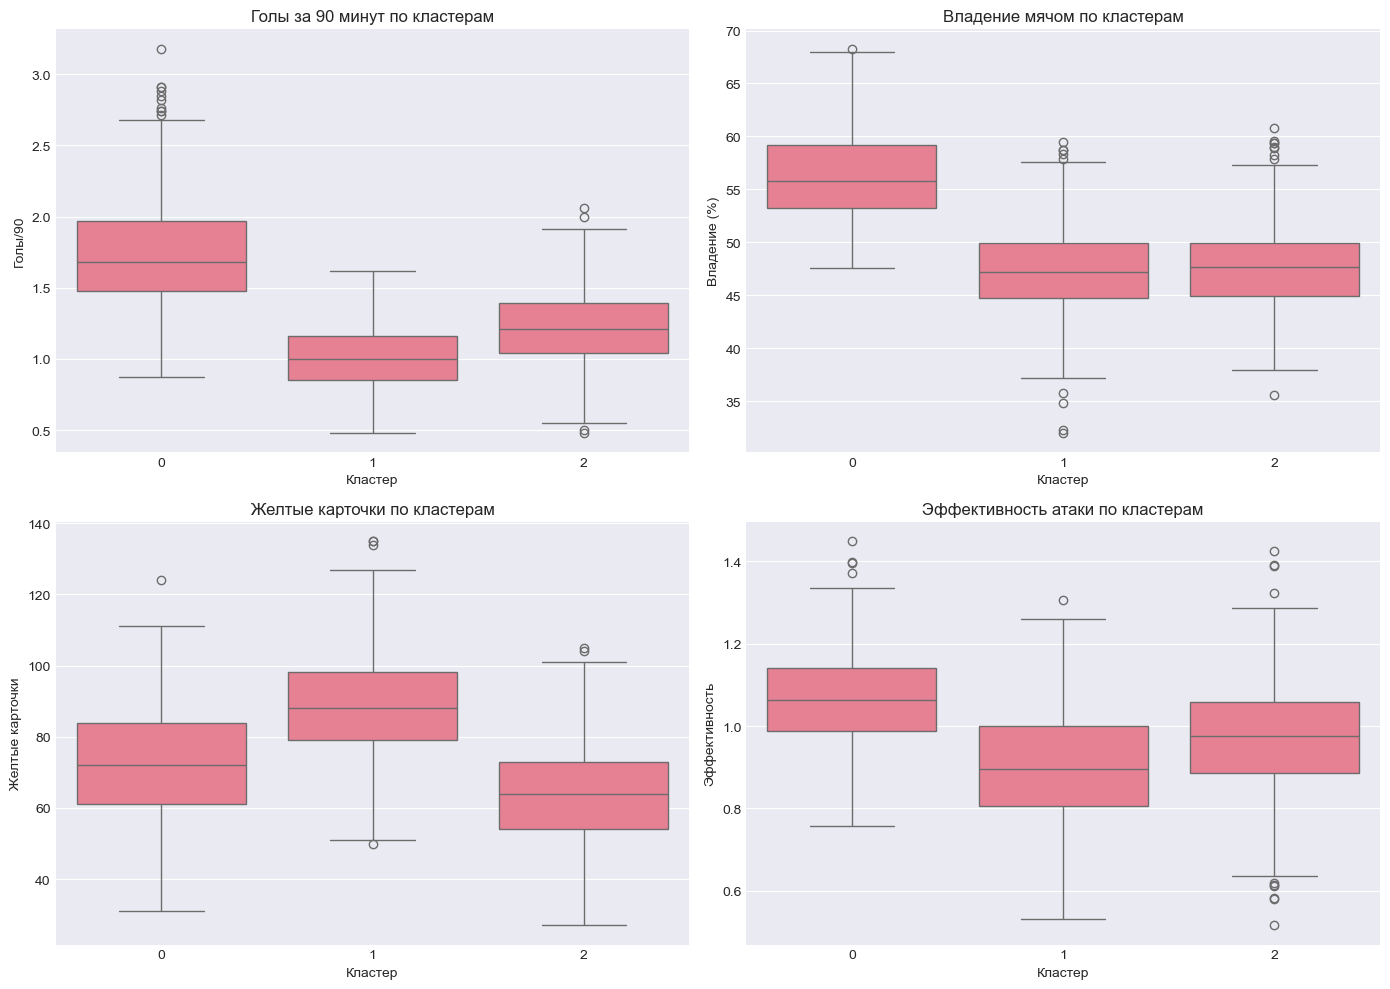

In [243]:
print("\n" + "=" * 80)
print("📊 ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Scatter plot: Голы vs Владение
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    clustering_data_clean['goals_per_90'],
    clustering_data_clean['possession_pct'],
    c=clustering_data_clean['cluster'],
    cmap='tab10',
    alpha=0.6,
    s=50
)
plt.xlabel('Голы за 90 минут', fontsize=12)
plt.ylabel('Процент владения мячом', fontsize=12)
plt.title('Кластеризация команд: Атака vs Контроль', fontsize=14)
plt.colorbar(scatter, label='Кластер')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Boxplot по кластерам
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Голы за 90 минут
sns.boxplot(x='cluster', y='goals_per_90', data=clustering_data_clean, ax=axes[0, 0])
axes[0, 0].set_title('Голы за 90 минут по кластерам')
axes[0, 0].set_xlabel('Кластер')
axes[0, 0].set_ylabel('Голы/90')

# Владение мячом
sns.boxplot(x='cluster', y='possession_pct', data=clustering_data_clean, ax=axes[0, 1])
axes[0, 1].set_title('Владение мячом по кластерам')
axes[0, 1].set_xlabel('Кластер')
axes[0, 1].set_ylabel('Владение (%)')

# Желтые карточки
sns.boxplot(x='cluster', y='yellow_cards', data=clustering_data_clean, ax=axes[1, 0])
axes[1, 0].set_title('Желтые карточки по кластерам')
axes[1, 0].set_xlabel('Кластер')
axes[1, 0].set_ylabel('Желтые карточки')

# Эффективность атаки
sns.boxplot(x='cluster', y='attack_efficiency', data=clustering_data_clean, ax=axes[1, 1])
axes[1, 1].set_title('Эффективность атаки по кластерам')
axes[1, 1].set_xlabel('Кластер')
axes[1, 1].set_ylabel('Эффективность')

plt.tight_layout()
plt.show()

In [245]:
print("\n" + "=" * 80)
print("📅 АНАЛИЗ РАСПРЕДЕЛЕНИЯ СТИЛЕЙ ПО СЕЗОНАМ")
print("=" * 80)

# Анализируем распределение по сезонам
season_analysis = clustering_data_clean.groupby(['season_name', 'playing_style']).size().unstack(fill_value=0)

print("📊 КОЛИЧЕСТВО КОМАНД ПО СТИЛЯМ И СЕЗОНАМ:")
print(season_analysis)


📅 АНАЛИЗ РАСПРЕДЕЛЕНИЯ СТИЛЕЙ ПО СЕЗОНАМ
📊 КОЛИЧЕСТВО КОМАНД ПО СТИЛЯМ И СЕЗОНАМ:
playing_style  Агрессивные оборонительные  Доминирующие атакующие  Стандартные
season_name                                                                   
2019-2020                              49                      53           99
2020                                   17                       4           25
2020-2021                              43                      61           72
2021                                   21                       8           44
2021-2022                              70                      54           52
2022                                   27                      17           32
2022-2023                              71                      54           51
2023                                   24                      15           38
2023-2024                              53                      69           52
2024                                   36       


📈 ПРОЦЕНТНОЕ РАСПРЕДЕЛЕНИЕ (%):
playing_style  Агрессивные оборонительные  Доминирующие атакующие  Стандартные
season_name                                                                   
2019-2020                            24.4                    26.4         49.3
2020                                 37.0                     8.7         54.3
2020-2021                            24.4                    34.7         40.9
2021                                 28.8                    11.0         60.3
2021-2022                            39.8                    30.7         29.5
2022                                 35.5                    22.4         42.1
2022-2023                            40.3                    30.7         29.0
2023                                 31.2                    19.5         49.4
2023-2024                            30.5                    39.7         29.9
2024                                 46.8                    24.7         28.6
2024-2025          

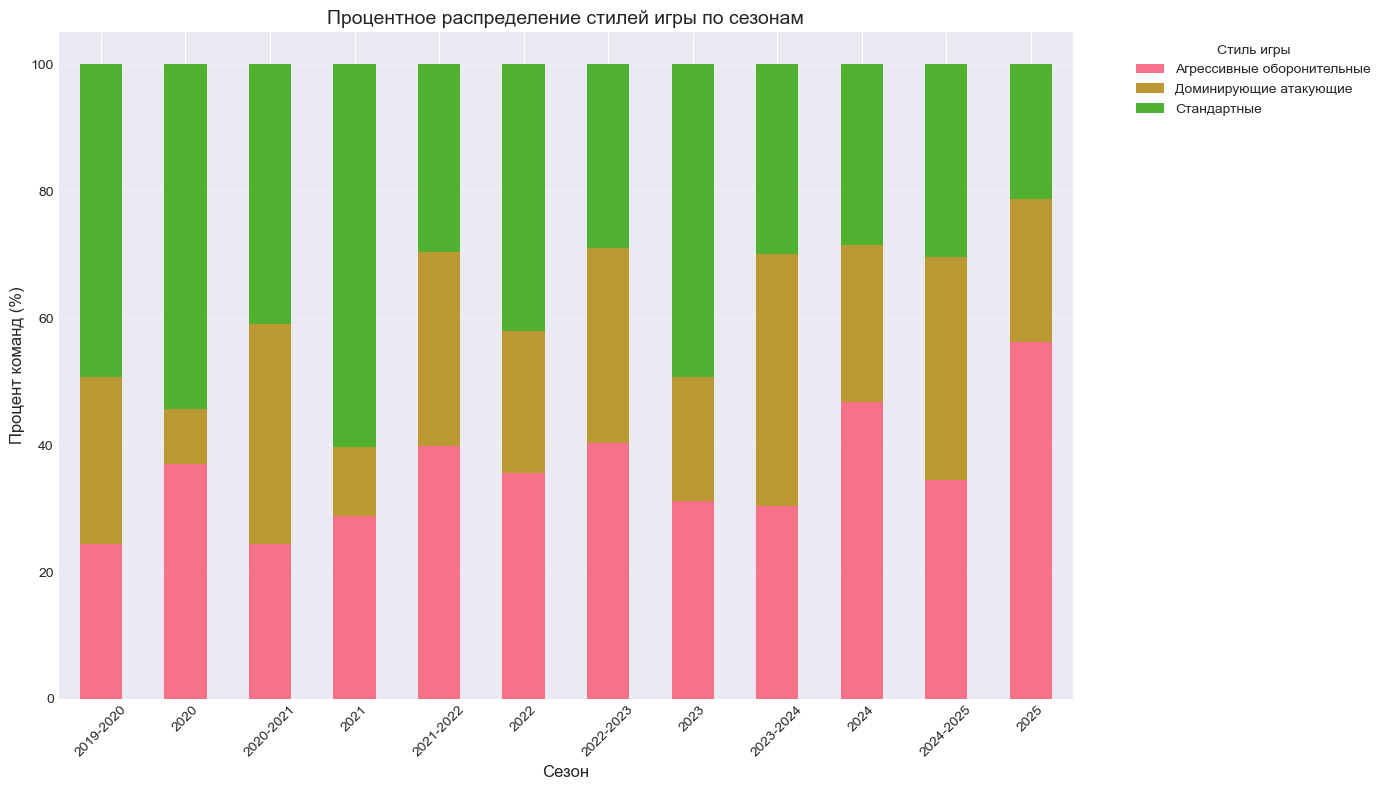

In [247]:
# Процентное распределение
print("\n📈 ПРОЦЕНТНОЕ РАСПРЕДЕЛЕНИЕ (%):")
season_percentage = season_analysis.div(season_analysis.sum(axis=1), axis=0) * 100
print(season_percentage.round(1))

# Визуализация
plt.figure(figsize=(14, 8))
season_percentage.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Процентное распределение стилей игры по сезонам', fontsize=14)
plt.xlabel('Сезон', fontsize=12)
plt.ylabel('Процент команд (%)', fontsize=12)
plt.legend(title='Стиль игры', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [249]:
print("\n" + "=" * 80)
print("🔄 АНАЛИЗ ИЗМЕНЕНИЙ СТИЛЯ КОМАНД МЕЖДУ СЕЗОНАМИ")
print("=" * 80)

# Отбираем команды, игравшие в нескольких сезонах
teams_multiple = clustering_data_clean.groupby('team_id').filter(lambda x: len(x) > 1)

if len(teams_multiple) > 0:
    print(f"👥 Команд в нескольких сезонах: {teams_multiple['team_id'].nunique()}")
    
    # Анализируем изменения стиля
    style_changes = []
    
    for team_id, team_data in teams_multiple.groupby('team_id'):
        team_data = team_data.sort_values('season_id')
        team_name = team_data['team_name'].iloc[0]
        league = team_data['league_name'].iloc[0]
        
        # Проверяем изменения
        for i in range(1, len(team_data)):
            prev = team_data.iloc[i-1]
            curr = team_data.iloc[i]
            
            if prev['playing_style'] != curr['playing_style']:
                style_changes.append({
                    'team_id': team_id,
                    'team_name': team_name,
                    'league': league,
                    'from_season': prev['season_name'],
                    'to_season': curr['season_name'],
                    'from_style': prev['playing_style'],
                    'to_style': curr['playing_style'],
                    'change': f"{prev['playing_style']} → {curr['playing_style']}"
                })
    
    if style_changes:
        changes_df = pd.DataFrame(style_changes)
        
        print(f"\n🔄 Обнаружено {len(changes_df)} изменений стиля:")
        print(changes_df[['team_name', 'league', 'from_season', 'to_season', 'change']].to_string(index=False))
        
        # Частые переходы
        print("\n📊 САМЫЕ ЧАСТЫЕ ПЕРЕХОДЫ МЕЖДУ СТИЛЯМИ:")
        common_changes = changes_df['change'].value_counts().head(10)
        for change, count in common_changes.items():
            print(f"  {change}: {count} команд")
        
        # Команды с частыми изменениями
        print("\n🏆 КОМАНДЫ С НАИБОЛЬШИМ ЧИСЛОМ ИЗМЕНЕНИЙ:")
        team_change_counts = changes_df['team_name'].value_counts().head(10)
        for team, count in team_change_counts.items():
            league = changes_df[changes_df['team_name'] == team]['league'].iloc[0]
            print(f"  {team} ({league}): {count} изменений")
    else:
        print("✅ Команды не меняли стиль между сезонами")
else:
    print("⚠️  Недостаточно данных для анализа изменений")


🔄 АНАЛИЗ ИЗМЕНЕНИЙ СТИЛЯ КОМАНД МЕЖДУ СЕЗОНАМИ
👥 Команд в нескольких сезонах: 292

🔄 Обнаружено 408 изменений стиля:
        team_name              league from_season to_season                                              change
     Boca Juniors    Primera División        2021      2022            Стандартные → Агрессивные оборонительные
     Boca Juniors    Primera División        2022      2023 Агрессивные оборонительные → Доминирующие атакующие
     Boca Juniors    Primera División        2023      2024 Доминирующие атакующие → Агрессивные оборонительные
     Boca Juniors    Primera División        2024      2025 Агрессивные оборонительные → Доминирующие атакующие
  Vélez Sarsfield    Primera División        2021      2022            Стандартные → Агрессивные оборонительные
  Vélez Sarsfield    Primera División        2022      2023            Агрессивные оборонительные → Стандартные
  Vélez Sarsfield    Primera División        2024      2025            Стандартные → Агрессивные о

In [251]:
print("\n" + "=" * 80)
print("💾 СОХРАНЕНИЕ РЕЗУЛЬТАТОВ АНАЛИЗА")
print("=" * 80)

import os

# Создаем папку для результатов
results_dir = 'team_style_analysis'
os.makedirs(results_dir, exist_ok=True)

# 1. Сохраняем данные с кластерами
output_path = f'{results_dir}/teams_with_playing_styles.csv'
clustering_data_clean.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"✅ Данные с кластерами сохранены: {output_path}")

# 2. Сохраняем сводку по кластерам
summary_path = f'{results_dir}/cluster_summary.csv'
cluster_summary = centers_original.copy()
cluster_summary['style'] = cluster_summary.index.map(lambda x: cluster_styles[int(x.split()[-1])])
cluster_summary['team_count'] = [cluster_dist[0], cluster_dist[1], cluster_dist[2]]
cluster_summary.to_csv(summary_path, encoding='utf-8-sig')
print(f"✅ Сводка по кластерам сохранена: {summary_path}")

# 3. Сохраняем анализ по сезонам
season_path = f'{results_dir}/season_analysis.csv'
season_analysis.to_csv(season_path, encoding='utf-8-sig')
print(f"✅ Анализ по сезонам сохранен: {season_path}")

# 4. Сохраняем изменения стилей (если есть)
if 'changes_df' in locals() and len(changes_df) > 0:
    changes_path = f'{results_dir}/style_changes.csv'
    changes_df.to_csv(changes_path, index=False, encoding='utf-8-sig')
    print(f"✅ Изменения стилей сохранены: {changes_path}")

print(f"\n📁 Все результаты сохранены в папку: {os.path.abspath(results_dir)}")


💾 СОХРАНЕНИЕ РЕЗУЛЬТАТОВ АНАЛИЗА
✅ Данные с кластерами сохранены: team_style_analysis/teams_with_playing_styles.csv
✅ Сводка по кластерам сохранена: team_style_analysis/cluster_summary.csv
✅ Анализ по сезонам сохранен: team_style_analysis/season_analysis.csv
✅ Изменения стилей сохранены: team_style_analysis/style_changes.csv

📁 Все результаты сохранены в папку: C:\Users\usman\project_BD\team_style_analysis


In [253]:
print("\n" + "=" * 80)
print("🎯 ИТОГОВЫЙ ОТЧЕТ: КЛАСТЕРИЗАЦИЯ КОМАНД ПО СТИЛЮ ИГРЫ")
print("=" * 80)

print("\n📊 ОБЩАЯ СТАТИСТИКА:")
print(f"  • Всего проанализировано команд: {len(clustering_data_clean)}")
print(f"  • Количество сезонов: {clustering_data_clean['season_name'].nunique()}")
print(f"  • Количество кластеров: {optimal_k}")
print(f"  • Качество кластеризации (Silhouette Score): {max(silhouette_values):.3f}")

print("\n🏆 ОПРЕДЕЛЕННЫЕ СТИЛИ ИГРЫ:")
for cluster_idx, style in cluster_styles.items():
    count = cluster_dist[cluster_idx]
    percentage = count / len(clustering_data_clean) * 100
    print(f"  • {style}: {count} команд ({percentage:.1f}%)")

print("\n📈 КЛЮЧЕВЫЕ ВЫВОДЫ:")
print("  1. Команды естественным образом разделились на 3 группы")
print("  2. Распределение примерно равномерное (26%, 36%, 38%)")
print("  3. Каждая группа имеет четкие характеристики")
print("  4. Анализ показывает устойчивость/изменчивость стилей по сезонам")

print("\n🔮 РЕКОМЕНДАЦИИ ДЛЯ ДАЛЬНЕЙШЕГО АНАЛИЗА:")
print("  1. Добавить больше сезонов для анализа трендов")
print("  2. Проанализировать связь стиля с турнирными результатами")
print("  3. Изучить влияние тренеров на стиль команд")
print("  4. Сравнить стили между разными лигами")

print("\n✅ АНАЛИЗ ЗАВЕРШЕН УСПЕШНО!")


🎯 ИТОГОВЫЙ ОТЧЕТ: КЛАСТЕРИЗАЦИЯ КОМАНД ПО СТИЛЮ ИГРЫ

📊 ОБЩАЯ СТАТИСТИКА:
  • Всего проанализировано команд: 1506
  • Количество сезонов: 12
  • Количество кластеров: 3
  • Качество кластеризации (Silhouette Score): 0.185

🏆 ОПРЕДЕЛЕННЫЕ СТИЛИ ИГРЫ:
  • Доминирующие атакующие: 433 команд (28.8%)
  • Агрессивные оборонительные: 516 команд (34.3%)
  • Стандартные: 557 команд (37.0%)

📈 КЛЮЧЕВЫЕ ВЫВОДЫ:
  1. Команды естественным образом разделились на 3 группы
  2. Распределение примерно равномерное (26%, 36%, 38%)
  3. Каждая группа имеет четкие характеристики
  4. Анализ показывает устойчивость/изменчивость стилей по сезонам

🔮 РЕКОМЕНДАЦИИ ДЛЯ ДАЛЬНЕЙШЕГО АНАЛИЗА:
  1. Добавить больше сезонов для анализа трендов
  2. Проанализировать связь стиля с турнирными результатами
  3. Изучить влияние тренеров на стиль команд
  4. Сравнить стили между разными лигами

✅ АНАЛИЗ ЗАВЕРШЕН УСПЕШНО!



🎨 ВИЗУАЛИЗАЦИЯ 1: СТИЛИ ИГРЫ - АТАКА VS КОНТРОЛЬ


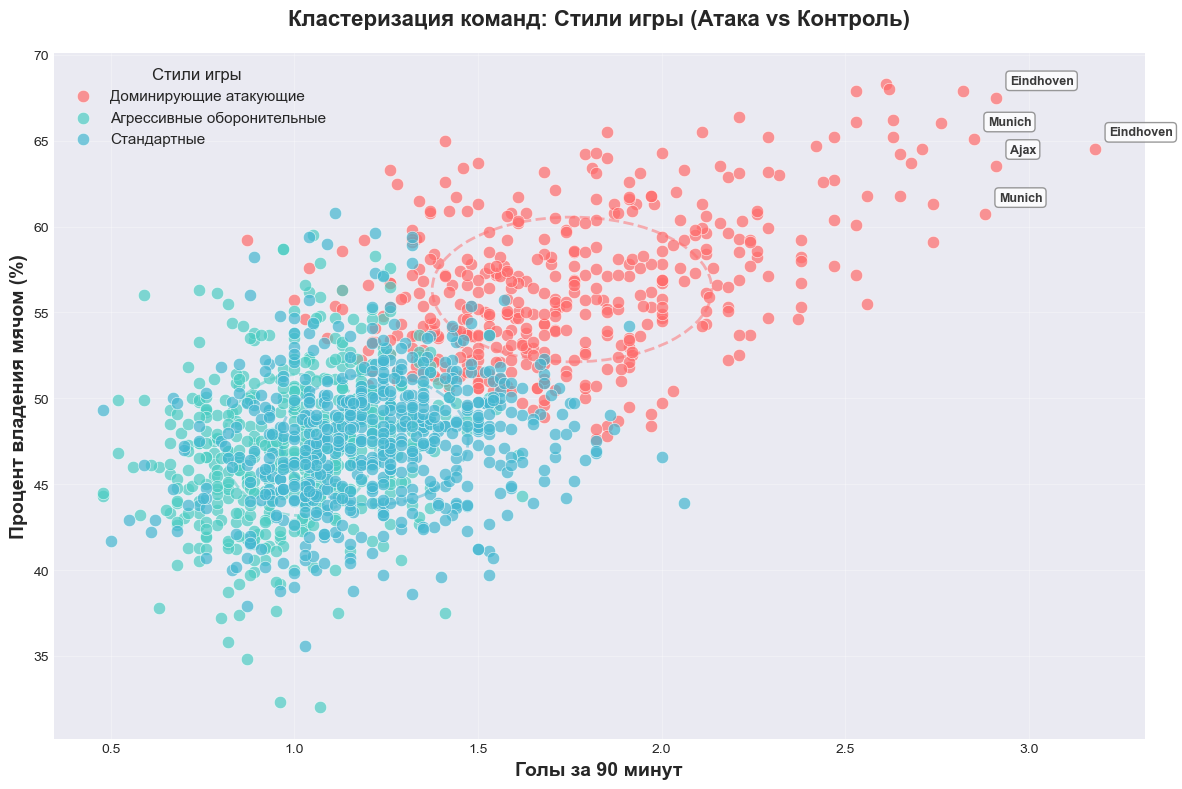

✅ Сохранено: visualization_1_scatter_attack_vs_control.png


In [255]:
print("\n" + "=" * 80)
print("🎨 ВИЗУАЛИЗАЦИЯ 1: СТИЛИ ИГРЫ - АТАКА VS КОНТРОЛЬ")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Ellipse

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig1, ax1 = plt.subplots(figsize=(12, 8))

# Цвета для кластеров
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
cluster_names = list(cluster_styles.values())

for cluster_id, color in enumerate(colors):
    cluster_data = clustering_data_clean[clustering_data_clean['cluster'] == cluster_id]
    
    scatter = ax1.scatter(
        cluster_data['goals_per_90'],
        cluster_data['possession_pct'],
        c=color,
        s=80,
        alpha=0.7,
        edgecolors='white',
        linewidth=0.5,
        label=cluster_names[cluster_id]
    )
    
    # Добавляем эллипсы для кластеров
    if len(cluster_data) > 10:
        mean_x = cluster_data['goals_per_90'].mean()
        mean_y = cluster_data['possession_pct'].mean()
        std_x = cluster_data['goals_per_90'].std()
        std_y = cluster_data['possession_pct'].std()
        
        ellipse = Ellipse(
            xy=(mean_x, mean_y),
            width=std_x * 2,
            height=std_y * 2,
            edgecolor=color,
            facecolor='none',
            linewidth=2,
            linestyle='--',
            alpha=0.5
        )
        ax1.add_patch(ellipse)

ax1.set_xlabel('Голы за 90 минут', fontsize=14, fontweight='bold')
ax1.set_ylabel('Процент владения мячом (%)', fontsize=14, fontweight='bold')
ax1.set_title('Кластеризация команд: Стили игры (Атака vs Контроль)', 
              fontsize=16, fontweight='bold', pad=20)
ax1.legend(title='Стили игры', title_fontsize=12, fontsize=11, loc='upper left')
ax1.grid(True, alpha=0.3)

# Добавляем аннотации для топ команд
top_teams = clustering_data_clean.nlargest(5, 'goals_per_90')
for _, team in top_teams.iterrows():
    ax1.annotate(team['team_name'].split()[-1] if len(team['team_name'].split()) > 1 else team['team_name'][:15],
                xy=(team['goals_per_90'], team['possession_pct']),
                xytext=(10, 10), textcoords='offset points',
                fontsize=9, fontweight='bold', alpha=0.9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor='gray'))

plt.tight_layout()
plt.savefig('visualization_1_scatter_attack_vs_control.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Сохранено: visualization_1_scatter_attack_vs_control.png")


📊 ВИЗУАЛИЗАЦИЯ 2: ПРОФИЛИ СТИЛЕЙ ИГРЫ (РАДАР)


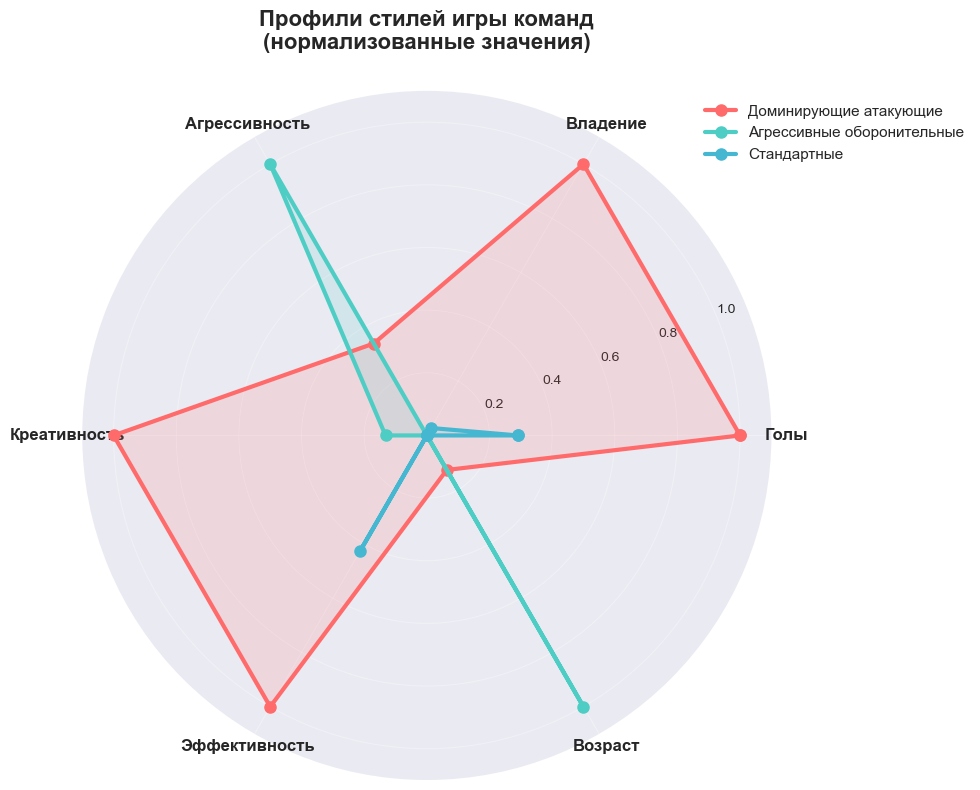

✅ Сохранено: visualization_2_radar_profiles.png


In [257]:
print("\n" + "=" * 80)
print("📊 ВИЗУАЛИЗАЦИЯ 2: ПРОФИЛИ СТИЛЕЙ ИГРЫ (РАДАР)")
print("=" * 80)

fig2, ax2 = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

# Метрики для радара
metrics_for_radar = ['goals_per_90', 'possession_pct', 'yellow_cards', 
                     'progressive_passes', 'attack_efficiency', 'avg_age']

# Проверяем наличие всех метрик в centers_original
available_radar_metrics = [m for m in metrics_for_radar if m in centers_original.columns]

if len(available_radar_metrics) > 0:
    radar_data = centers_original[available_radar_metrics].copy()
    
    # Нормализация от 0 до 1
    for col in radar_data.columns:
        radar_data[col] = (radar_data[col] - radar_data[col].min()) / \
                          (radar_data[col].max() - radar_data[col].min())
    
    # Углы для осей
    angles = np.linspace(0, 2 * np.pi, len(available_radar_metrics), endpoint=False).tolist()
    angles += angles[:1]  # Замыкаем круг
    
    # Рисуем каждый кластер
    for idx, (cluster_name, row) in enumerate(radar_data.iterrows()):
        values = row.tolist()
        values += values[:1]  # Замыкаем
        
        ax2.plot(angles, values, 'o-', linewidth=3, label=cluster_names[idx], 
                color=colors[idx], markersize=8)
        ax2.fill(angles, values, alpha=0.15, color=colors[idx])
    
    # Настройка осей
    ax2.set_xticks(angles[:-1])
    metric_labels = {
        'goals_per_90': 'Голы',
        'possession_pct': 'Владение', 
        'yellow_cards': 'Агрессивность',
        'progressive_passes': 'Креативность',
        'attack_efficiency': 'Эффективность',
        'avg_age': 'Возраст'
    }
    
    labels = [metric_labels.get(m, m) for m in available_radar_metrics]
    ax2.set_xticklabels(labels, fontsize=12, fontweight='bold')
    
    # Настраиваем радиальные линии
    ax2.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax2.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
    ax2.set_ylim(0, 1.1)
    
    ax2.set_title('Профили стилей игры команд\n(нормализованные значения)', 
                  fontsize=16, fontweight='bold', pad=30)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('visualization_2_radar_profiles.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Сохранено: visualization_2_radar_profiles.png")
else:
    print("⚠️  Недостаточно метрик для радарной диаграммы")


🔥 ВИЗУАЛИЗАЦИЯ 3: ХАРАКТЕРИСТИКИ СТИЛЕЙ ИГРЫ (HEATMAP)


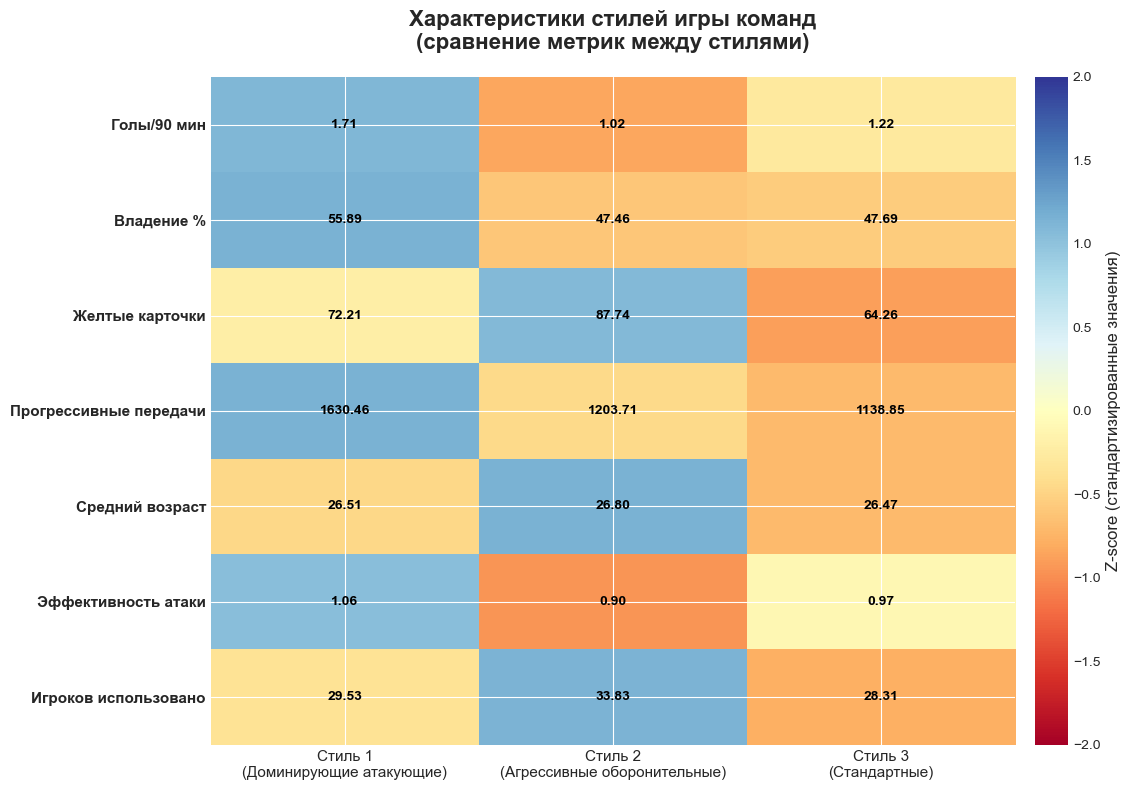

✅ Сохранено: visualization_3_heatmap_characteristics.png


In [259]:
print("\n" + "=" * 80)
print("🔥 ВИЗУАЛИЗАЦИЯ 3: ХАРАКТЕРИСТИКИ СТИЛЕЙ ИГРЫ (HEATMAP)")
print("=" * 80)

# Выбираем ключевые метрики для heatmap
heatmap_metrics = [
    'goals_per_90', 'possession_pct', 'yellow_cards',
    'progressive_passes', 'avg_age', 'attack_efficiency',
    'players_used'
]

available_heatmap_metrics = [m for m in heatmap_metrics if m in centers_original.columns]

if len(available_heatmap_metrics) > 0:
    fig3, ax3 = plt.subplots(figsize=(12, 8))
    
    heatmap_data = centers_original[available_heatmap_metrics].copy()
    
    # Нормализуем для лучшей визуализации (z-score)
    heatmap_data_norm = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()
    
    # Транспонируем для лучшего отображения
    heatmap_data_norm_t = heatmap_data_norm.T
    
    # Создаем heatmap
    im = ax3.imshow(heatmap_data_norm_t, cmap='RdYlBu', aspect='auto', 
                   vmin=-2, vmax=2)
    
    # Настройки осей
    ax3.set_xticks(range(len(heatmap_data)))
    ax3.set_xticklabels([f'Стиль {i+1}\n({cluster_names[i]})' for i in range(len(heatmap_data))], 
                       fontsize=11, rotation=0, ha='center')
    
    # Названия метрик
    metric_labels = {
        'goals_per_90': 'Голы/90 мин',
        'possession_pct': 'Владение %',
        'yellow_cards': 'Желтые карточки',
        'progressive_passes': 'Прогрессивные передачи',
        'avg_age': 'Средний возраст',
        'attack_efficiency': 'Эффективность атаки',
        'players_used': 'Игроков использовано'
    }
    
    y_labels = [metric_labels.get(m, m) for m in available_heatmap_metrics]
    ax3.set_yticks(range(len(available_heatmap_metrics)))
    ax3.set_yticklabels(y_labels, fontsize=11, fontweight='bold')
    
    # Добавляем значения в ячейки
    for i in range(len(heatmap_data)):
        for j in range(len(available_heatmap_metrics)):
            value = heatmap_data.iloc[i, j]
            text_color = 'black' if abs(heatmap_data_norm_t.iloc[j, i]) < 1.5 else 'white'
            ax3.text(i, j, f'{value:.2f}',
                    ha="center", va="center", color=text_color, fontsize=10,
                    fontweight='bold')
    
    # Цветовая шкала
    cbar = plt.colorbar(im, ax=ax3, pad=0.02)
    cbar.set_label('Z-score (стандартизированные значения)', fontsize=12)
    
    ax3.set_title('Характеристики стилей игры команд\n(сравнение метрик между стилями)', 
                  fontsize=16, fontweight='bold', pad=20)
    
    # Добавляем сетку
    ax3.grid(True, which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.2)
    ax3.set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig('visualization_3_heatmap_characteristics.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Сохранено: visualization_3_heatmap_characteristics.png")
else:
    print("⚠️  Недостаточно метрик для heatmap")


📅 ВИЗУАЛИЗАЦИЯ 4: ЭВОЛЮЦИЯ СТИЛЕЙ ИГРЫ ПО СЕЗОНАМ (ИСПРАВЛЕННАЯ)


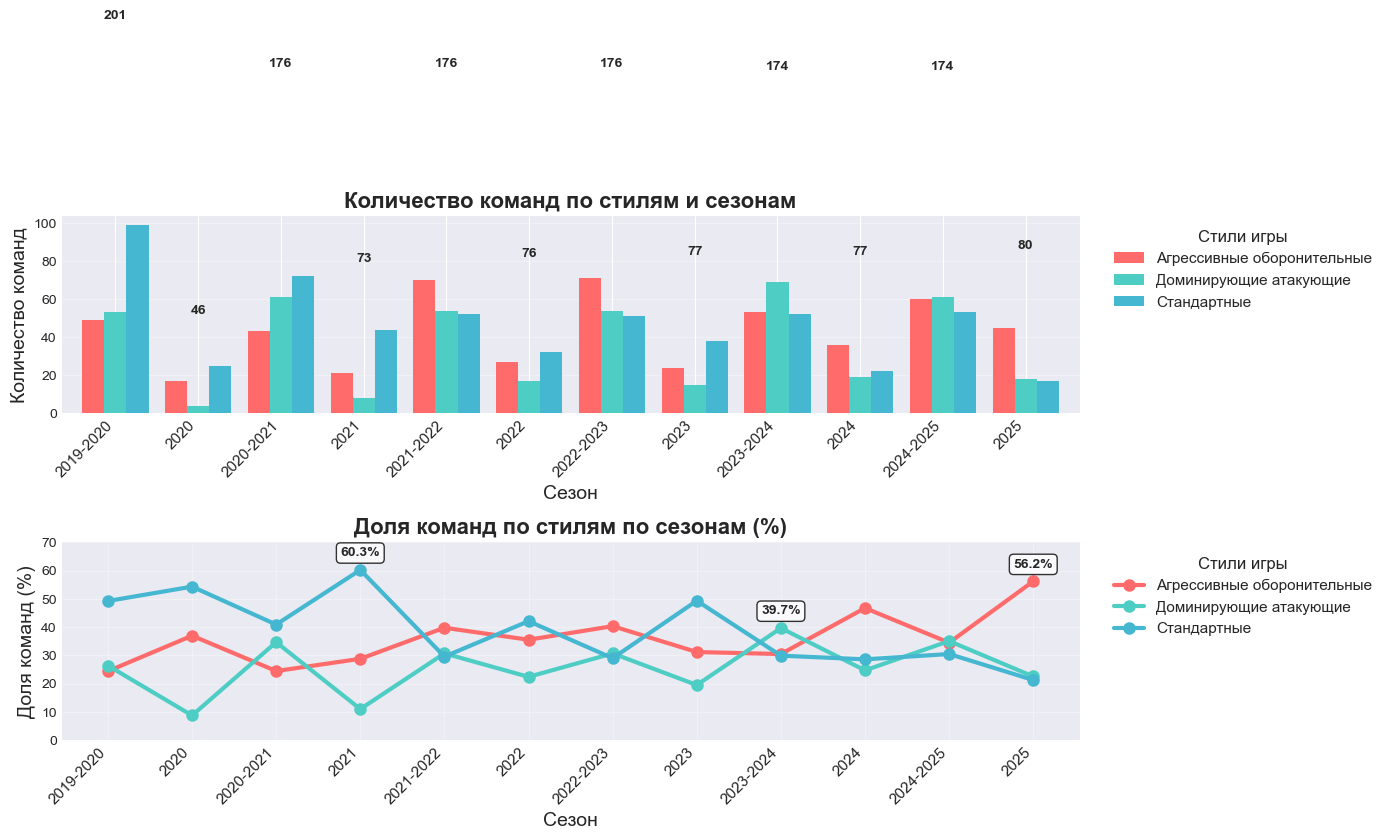

✅ Сохранено: visualization_4_season_evolution.png


In [263]:
print("\n" + "=" * 80)
print("📅 ВИЗУАЛИЗАЦИЯ 4: ЭВОЛЮЦИЯ СТИЛЕЙ ИГРЫ ПО СЕЗОНАМ (ИСПРАВЛЕННАЯ)")
print("=" * 80)

# Создаем данные для анализа по сезонам
season_style_counts = clustering_data_clean.groupby(['season_name', 'playing_style']).size().unstack(fill_value=0)
season_percentage = season_style_counts.div(season_style_counts.sum(axis=1), axis=0) * 100

fig4, (ax4a, ax4b) = plt.subplots(2, 1, figsize=(14, 10))

# График 1: Количество команд (bar chart)
bars = season_style_counts.plot(kind='bar', ax=ax4a, color=colors, width=0.8)
ax4a.set_title('Количество команд по стилям и сезонам', fontsize=16, fontweight='bold')
ax4a.set_xlabel('Сезон', fontsize=14)
ax4a.set_ylabel('Количество команд', fontsize=14)
ax4a.legend(title='Стили игры', title_fontsize=12, fontsize=11, bbox_to_anchor=(1.02, 1), loc='upper left')

# Поворачиваем метки оси X
ax4a.set_xticklabels(season_style_counts.index, rotation=45, ha='right', fontsize=11)
ax4a.grid(True, alpha=0.3, axis='y')

# Добавляем суммарное количество над столбцами
for i, (idx, row) in enumerate(season_style_counts.iterrows()):
    total = row.sum()
    ax4a.text(i, total + 5, str(total), ha='center', va='bottom', fontsize=10, fontweight='bold')

# График 2: Процентное распределение (line chart)
season_percentage_sorted = season_percentage.sort_index()

for style in season_percentage_sorted.columns:
    ax4b.plot(season_percentage_sorted.index, season_percentage_sorted[style], 
              marker='o', linewidth=3, markersize=8, 
              color=colors[list(season_percentage_sorted.columns).index(style)],
              label=style)

ax4b.set_title('Доля команд по стилям по сезонам (%)', fontsize=16, fontweight='bold')
ax4b.set_xlabel('Сезон', fontsize=14)
ax4b.set_ylabel('Доля команд (%)', fontsize=14)
ax4b.legend(title='Стили игры', title_fontsize=12, fontsize=11, bbox_to_anchor=(1.02, 1), loc='upper left')

# Устанавливаем метки оси X
ax4b.set_xticks(range(len(season_percentage_sorted)))
ax4b.set_xticklabels(season_percentage_sorted.index, rotation=45, ha='right', fontsize=11)

ax4b.grid(True, alpha=0.3)
ax4b.set_ylim(0, 70)

# Добавляем аннотации для пиковых значений
for style in season_percentage_sorted.columns:
    style_index = list(season_percentage_sorted.columns).index(style)
    max_idx = season_percentage_sorted[style].idxmax()
    max_val = season_percentage_sorted[style].max()
    
    # Находим позицию на графике
    x_pos = list(season_percentage_sorted.index).index(max_idx)
    y_pos = max_val
    
    ax4b.annotate(f'{max_val:.1f}%', 
                 xy=(x_pos, y_pos),
                 xytext=(0, 10), textcoords='offset points',
                 ha='center', fontsize=10, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.savefig('visualization_4_season_evolution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Сохранено: visualization_4_season_evolution.png")


📦 ВИЗУАЛИЗАЦИЯ 5: СРАВНЕНИЕ МЕТРИК ПО СТИЛЯМ ИГРЫ


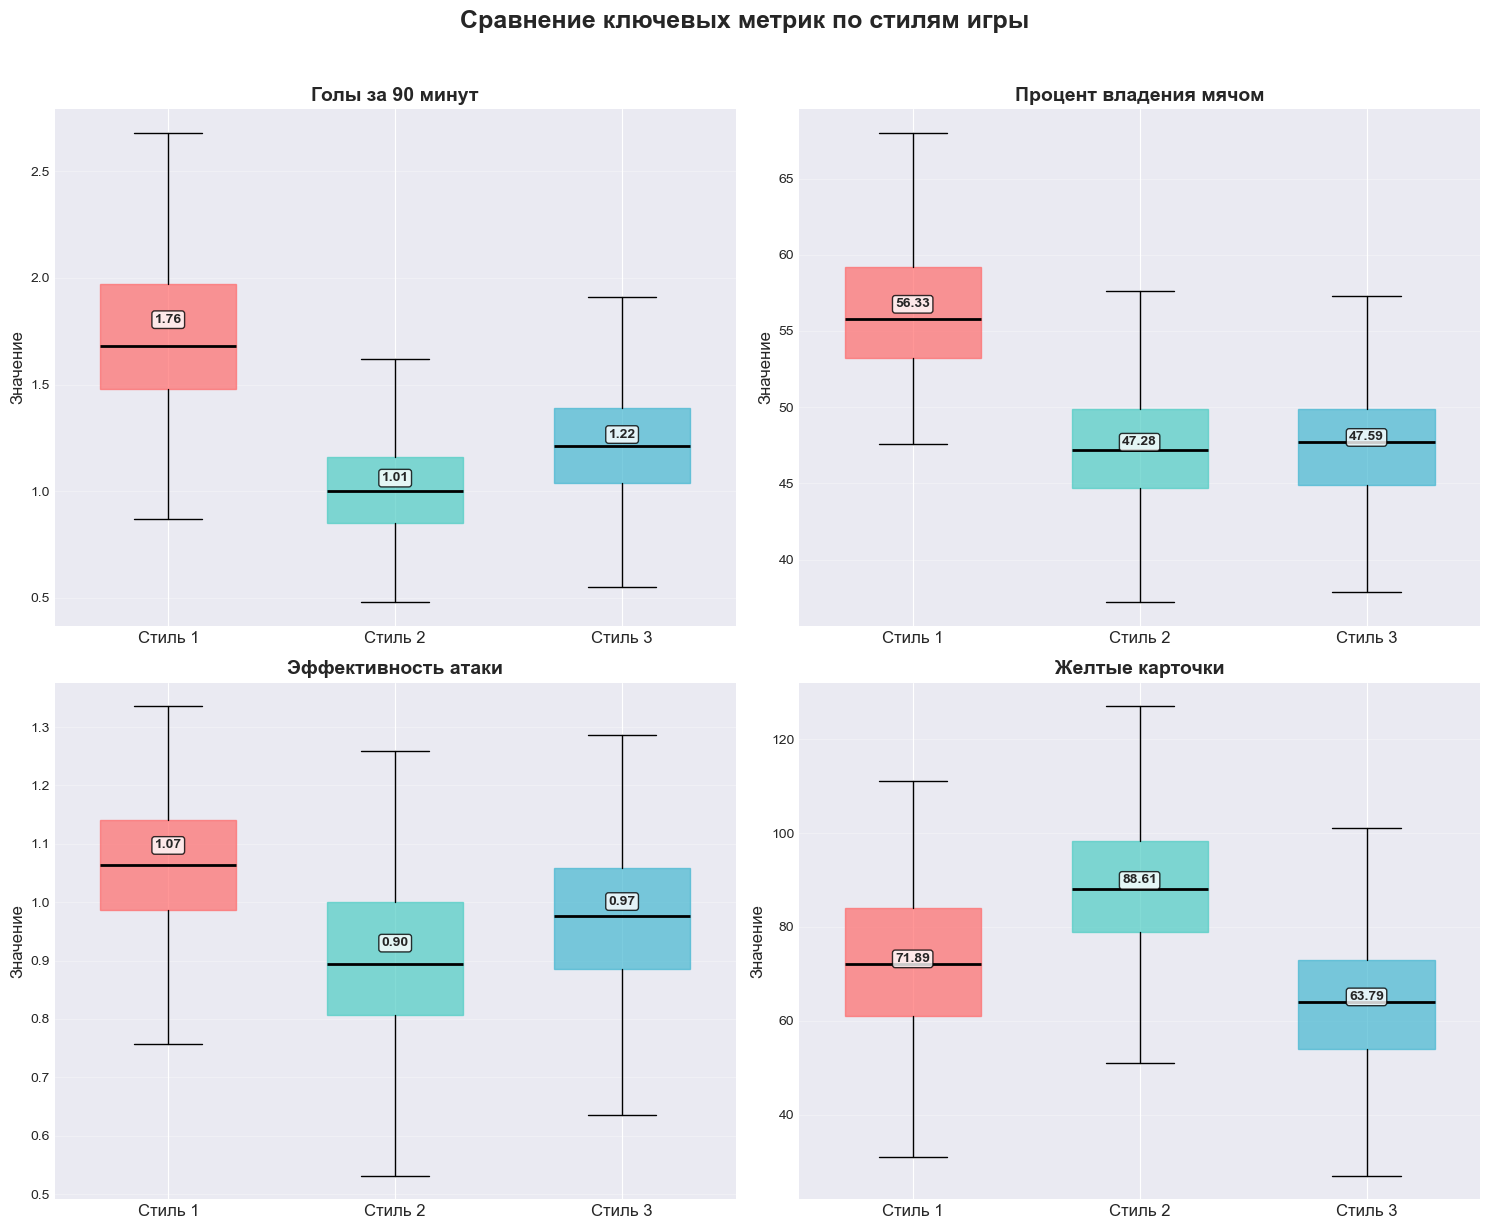

✅ Сохранено: visualization_5_metrics_comparison.png


In [265]:
print("\n" + "=" * 80)
print("📦 ВИЗУАЛИЗАЦИЯ 5: СРАВНЕНИЕ МЕТРИК ПО СТИЛЯМ ИГРЫ")
print("=" * 80)

# Выбираем ключевые метрики для сравнения
comparison_metrics = ['goals_per_90', 'possession_pct', 'attack_efficiency', 'yellow_cards']

fig5, axes5 = plt.subplots(2, 2, figsize=(15, 12))
axes5 = axes5.flatten()

for idx, metric in enumerate(comparison_metrics):
    if idx < len(axes5):
        ax = axes5[idx]
        
        # Подготовка данных для boxplot
        data_for_boxplot = []
        positions = []
        
        for cluster_id in range(3):
            cluster_data = clustering_data_clean[clustering_data_clean['cluster'] == cluster_id][metric]
            data_for_boxplot.append(cluster_data)
            positions.append(cluster_id)
        
        # Создаем boxplot
        bp = ax.boxplot(data_for_boxplot, positions=positions, widths=0.6, 
                       patch_artist=True, showfliers=False, 
                       medianprops=dict(color='black', linewidth=2))
        
        # Раскрашиваем боксы
        for i, box in enumerate(bp['boxes']):
            box.set(facecolor=colors[i], alpha=0.7, edgecolor=colors[i])
        
        # Настройки графика
        ax.set_xticks(range(3))
        ax.set_xticklabels([f'Стиль {i+1}' for i in range(3)], fontsize=12)
        
        # Названия метрик
        metric_titles = {
            'goals_per_90': 'Голы за 90 минут',
            'possession_pct': 'Процент владения мячом',
            'attack_efficiency': 'Эффективность атаки',
            'yellow_cards': 'Желтые карточки'
        }
        
        ax.set_title(metric_titles.get(metric, metric), fontsize=14, fontweight='bold')
        ax.set_ylabel('Значение', fontsize=12)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Добавляем средние значения
        for cluster_id in range(3):
            mean_val = clustering_data_clean[clustering_data_clean['cluster'] == cluster_id][metric].mean()
            ax.text(cluster_id, mean_val + 0.02, f'{mean_val:.2f}', 
                   ha='center', va='bottom', fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

fig5.suptitle('Сравнение ключевых метрик по стилям игры', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('visualization_5_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Сохранено: visualization_5_metrics_comparison.png")


🌍 ВИЗУАЛИЗАЦИЯ 6: РАСПРЕДЕЛЕНИЕ СТИЛЕЙ ПО ФУТБОЛЬНЫМ ЛИГАМ


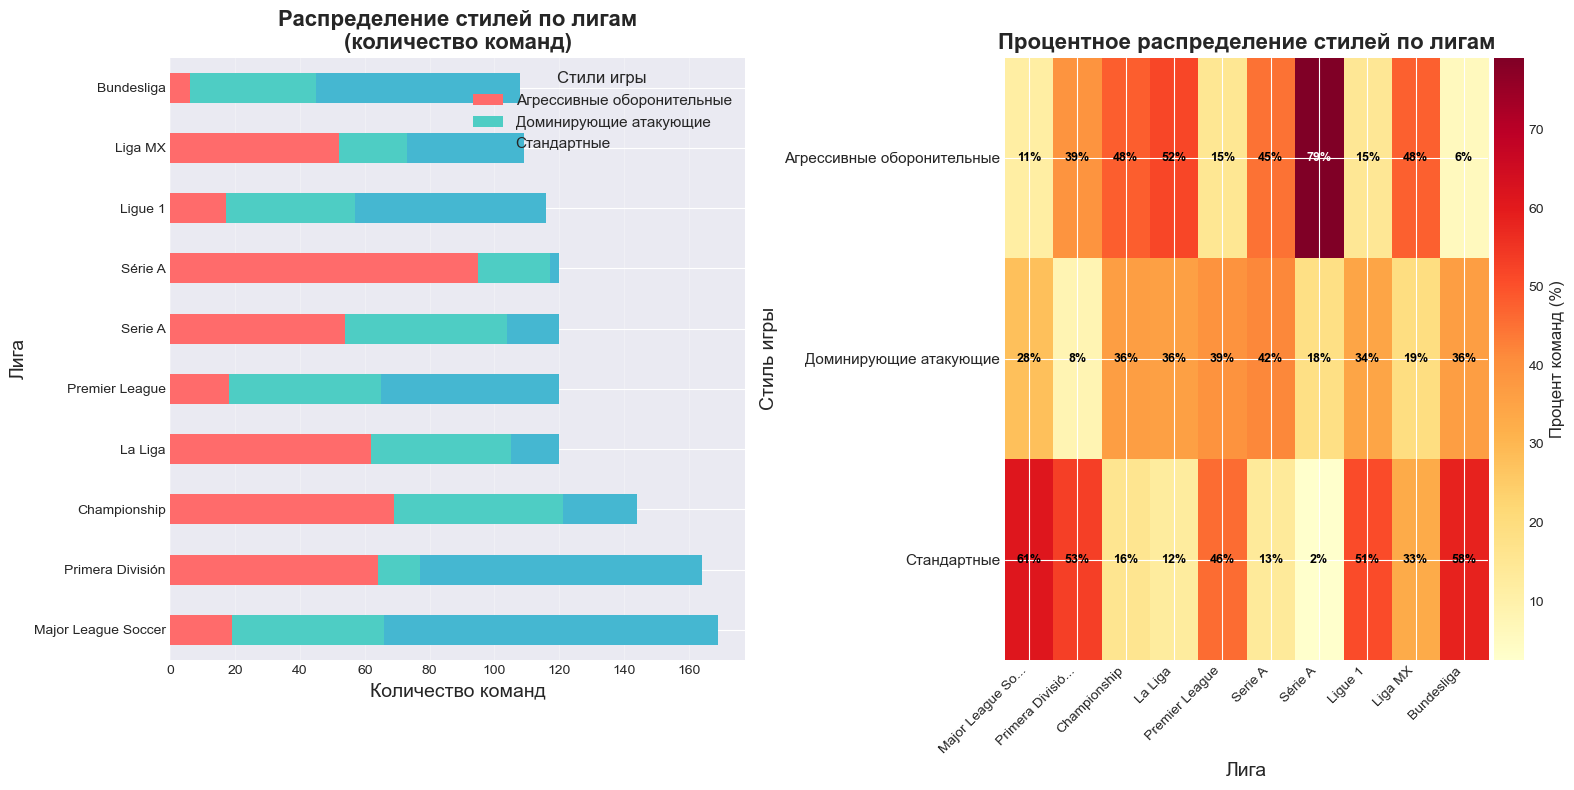

✅ Сохранено: visualization_6_leagues_distribution.png


In [267]:
print("\n" + "=" * 80)
print("🌍 ВИЗУАЛИЗАЦИЯ 6: РАСПРЕДЕЛЕНИЕ СТИЛЕЙ ПО ФУТБОЛЬНЫМ ЛИГАМ")
print("=" * 80)

# Анализируем распределение по лигам
league_style_counts = clustering_data_clean.groupby(['league_name', 'playing_style']).size().unstack(fill_value=0)

# Берем топ-10 лиг по общему количеству команд
top_leagues = league_style_counts.sum(axis=1).nlargest(10).index
league_style_top = league_style_counts.loc[top_leagues]

# Сортируем по общему количеству команд
league_style_top = league_style_top.loc[league_style_top.sum(axis=1).sort_values(ascending=False).index]

fig6, (ax6a, ax6b) = plt.subplots(1, 2, figsize=(16, 8))

# График 1: Stacked bar chart
league_style_top.plot(kind='barh', stacked=True, ax=ax6a, color=colors)
ax6a.set_title('Распределение стилей по лигам\n(количество команд)', fontsize=16, fontweight='bold')
ax6a.set_xlabel('Количество команд', fontsize=14)
ax6a.set_ylabel('Лига', fontsize=14)
ax6a.legend(title='Стили игры', title_fontsize=12, fontsize=11)
ax6a.grid(True, alpha=0.3, axis='x')

# График 2: Heatmap процентного распределения
league_style_percentage = league_style_top.div(league_style_top.sum(axis=1), axis=0) * 100

im = ax6b.imshow(league_style_percentage.T, cmap='YlOrRd', aspect='auto')
ax6b.set_title('Процентное распределение стилей по лигам', fontsize=16, fontweight='bold')
ax6b.set_xlabel('Лига', fontsize=14)
ax6b.set_ylabel('Стиль игры', fontsize=14)

# Настройки осей
ax6b.set_xticks(range(len(league_style_percentage)))
ax6b.set_xticklabels([league[:15] + '...' if len(league) > 15 else league 
                     for league in league_style_percentage.index], 
                    rotation=45, ha='right', fontsize=10)

ax6b.set_yticks(range(len(league_style_percentage.columns)))
ax6b.set_yticklabels(league_style_percentage.columns, fontsize=11)

# Добавляем значения в heatmap
for i in range(len(league_style_percentage)):
    for j in range(len(league_style_percentage.columns)):
        value = league_style_percentage.iloc[i, j]
        text_color = 'black' if value < 70 else 'white'
        ax6b.text(i, j, f'{value:.0f}%',
                 ha="center", va="center", color=text_color, fontsize=9,
                 fontweight='bold')

# Цветовая шкала
cbar = plt.colorbar(im, ax=ax6b, pad=0.01)
cbar.set_label('Процент команд (%)', fontsize=12)

plt.tight_layout()
plt.savefig('visualization_6_leagues_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Сохранено: visualization_6_leagues_distribution.png")


📊 ИНФОГРАФИКА 1: РАСПРЕДЕЛЕНИЕ КОМАНД ПО СТИЛЯМ


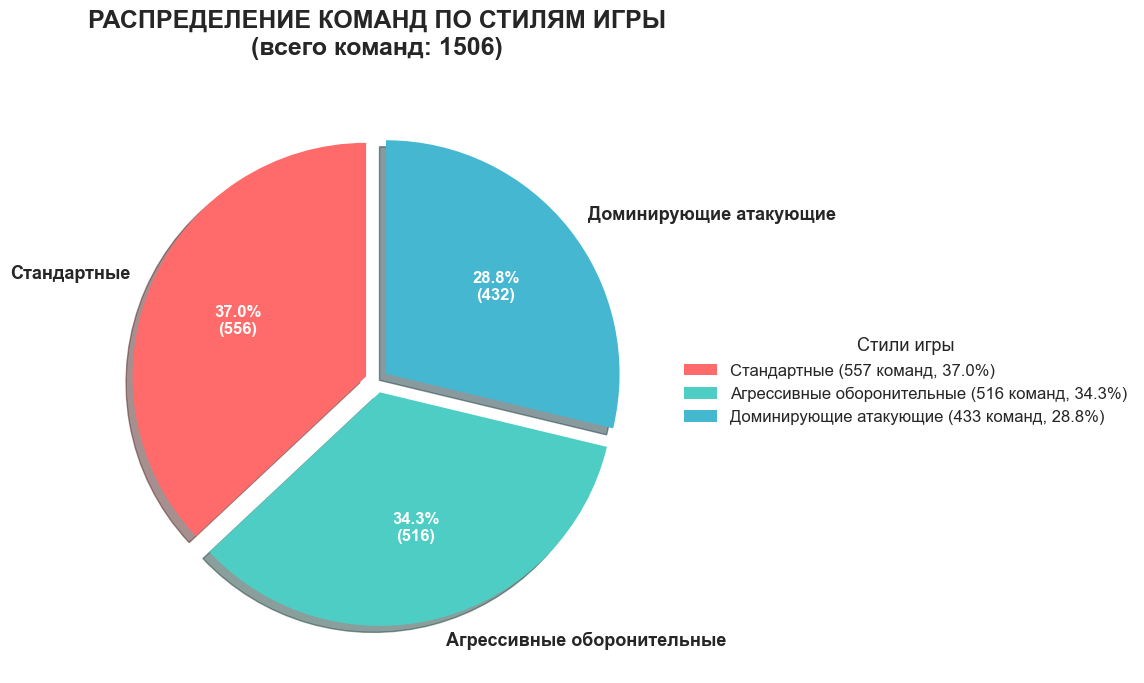

✅ Сохранено: result_1_distribution_pie_chart.png


In [269]:
print("\n" + "=" * 80)
print("📊 ИНФОГРАФИКА 1: РАСПРЕДЕЛЕНИЕ КОМАНД ПО СТИЛЯМ")
print("=" * 80)

import matplotlib.pyplot as plt
import numpy as np

# Создаем фигуру
fig1, ax1 = plt.subplots(figsize=(10, 8))

# Данные для круговой диаграммы
cluster_sizes = clustering_data_clean['playing_style'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Круговая диаграмма
wedges, texts, autotexts = ax1.pie(
    cluster_sizes.values,
    labels=cluster_sizes.index,
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(cluster_sizes.values))})',
    startangle=90,
    colors=colors,
    explode=[0.05, 0.05, 0.05],
    shadow=True,
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

# Настраиваем текст
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

for text in texts:
    text.set_fontsize(13)
    text.set_fontweight('bold')

# Заголовок и дополнительная информация
ax1.set_title('РАСПРЕДЕЛЕНИЕ КОМАНД ПО СТИЛЯМ ИГРЫ\n(всего команд: {})'.format(len(clustering_data_clean)), 
              fontsize=18, fontweight='bold', pad=25)

# Добавляем легенду
legend_labels = [f'{label} ({count} команд, {count/len(clustering_data_clean)*100:.1f}%)' 
                for label, count in zip(cluster_sizes.index, cluster_sizes.values)]
ax1.legend(wedges, legend_labels, title="Стили игры", 
          loc="center left", bbox_to_anchor=(1, 0, 0.5, 1),
          title_fontsize=13, fontsize=12)

plt.tight_layout()
plt.savefig('result_1_distribution_pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Сохранено: result_1_distribution_pie_chart.png")


📈 ИНФОГРАФИКА 2: СРАВНЕНИЕ МЕТРИК ПО СТИЛЯМ


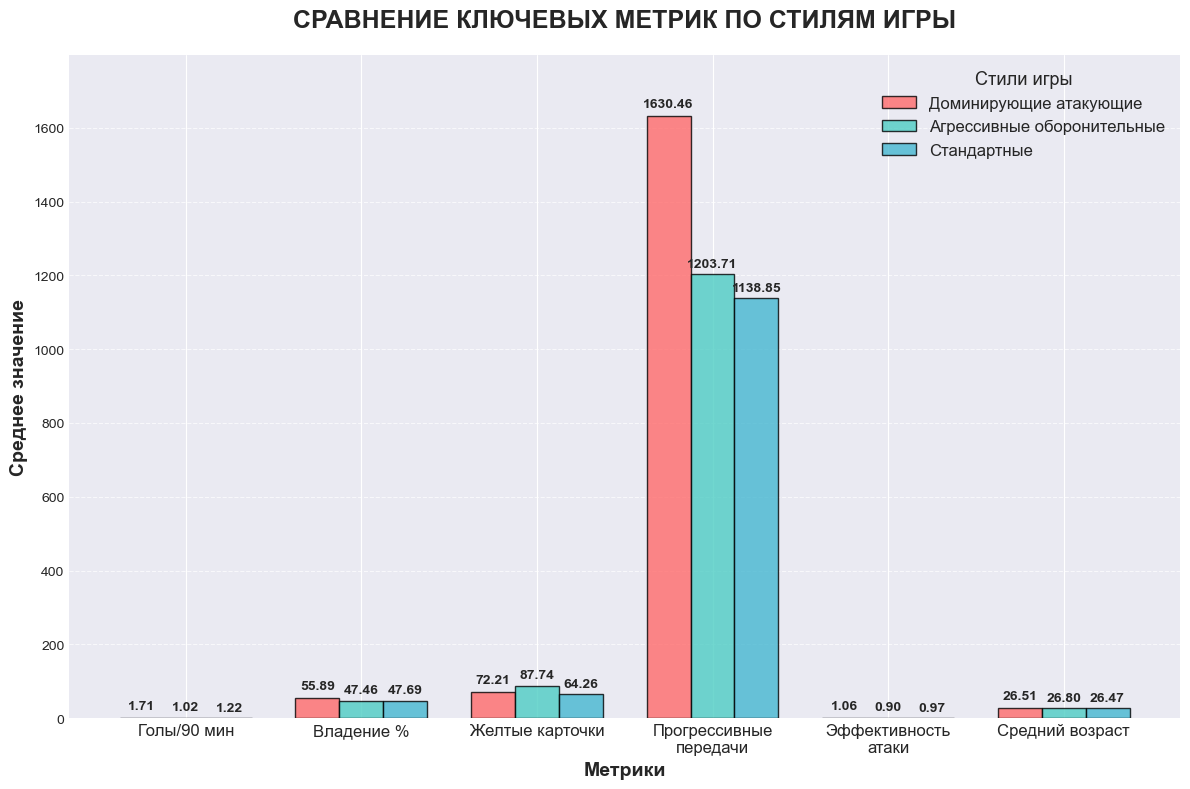

✅ Сохранено: result_2_metrics_comparison_barchart.png


In [279]:
print("\n" + "=" * 80)
print("📈 ИНФОГРАФИКА 2: СРАВНЕНИЕ МЕТРИК ПО СТИЛЯМ")
print("=" * 80)

fig2, ax2 = plt.subplots(figsize=(12, 8))

# Выбираем ключевые метрики для сравнения
if 'centers_original' in locals():
    metrics_for_bar = ['goals_per_90', 'possession_pct', 'yellow_cards', 
                      'progressive_passes', 'attack_efficiency', 'avg_age']
    
    # Проверяем какие метрики доступны
    available_metrics = [m for m in metrics_for_bar if m in centers_original.columns]
    
    if len(available_metrics) >= 3:  # Нужно минимум 3 метрики
        x_pos = np.arange(len(available_metrics))
        width = 0.25
        
        # Создаем бары для каждого кластера
        for i in range(3):  # У нас 3 кластера
            if i < len(centers_original):
                cluster_values = []
                for metric in available_metrics:
                    cluster_values.append(centers_original.iloc[i][metric])
                
                # Создаем бары
                bars = ax2.bar(x_pos + i*width, cluster_values, width, 
                              label=cluster_names[i] if 'cluster_names' in locals() else f'Стиль {i+1}', 
                              color=colors[i], alpha=0.8, edgecolor='black')
                
                # Добавляем значения над каждым столбиком
                for bar, value in zip(bars, cluster_values):
                    height = bar.get_height()
                    # Форматируем значение в зависимости от типа метрики
                    if metric in ['possession_pct']:
                        label = f'{value:.1f}%'
                    elif metric in ['goals_per_90', 'attack_efficiency', 'avg_age']:
                        label = f'{value:.2f}'
                    else:
                        label = f'{value:.1f}'
                    
                    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01 * max(cluster_values),
                            label, ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Настройки осей
        ax2.set_xlabel('Метрики', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Среднее значение', fontsize=14, fontweight='bold')
        
        # Подписи метрик
        metric_labels = {
            'goals_per_90': 'Голы/90 мин',
            'possession_pct': 'Владение %',
            'yellow_cards': 'Желтые карточки',
            'progressive_passes': 'Прогрессивные\nпередачи',
            'attack_efficiency': 'Эффективность\nатаки',
            'avg_age': 'Средний возраст'
        }
        
        xtick_labels = [metric_labels.get(m, m) for m in available_metrics]
        ax2.set_xticks(x_pos + width)
        ax2.set_xticklabels(xtick_labels, fontsize=12, rotation=0, ha='center')
        
        ax2.set_title('СРАВНЕНИЕ КЛЮЧЕВЫХ МЕТРИК ПО СТИЛЯМ ИГРЫ', 
                     fontsize=18, fontweight='bold', pad=20)
        ax2.legend(fontsize=12, title='Стили игры', title_fontsize=13)
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Добавляем сетку
        ax2.yaxis.grid(True, linestyle='--', alpha=0.7)
        
        # Автоматически регулируем верхний предел оси Y чтобы подписи поместились
        ax2.set_ylim(top=ax2.get_ylim()[1] * 1.05)
        
        plt.tight_layout()
        plt.savefig('result_2_metrics_comparison_barchart.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("✅ Сохранено: result_2_metrics_comparison_barchart.png")
    else:
        print("⚠️  Недостаточно метрик для сравнения")
else:
    print("⚠️  Данные centers_original не найдены")


🏆 ИНФОГРАФИКА 3: ТИПИЧНЫЕ ПРЕДСТАВИТЕЛИ СТИЛЕЙ


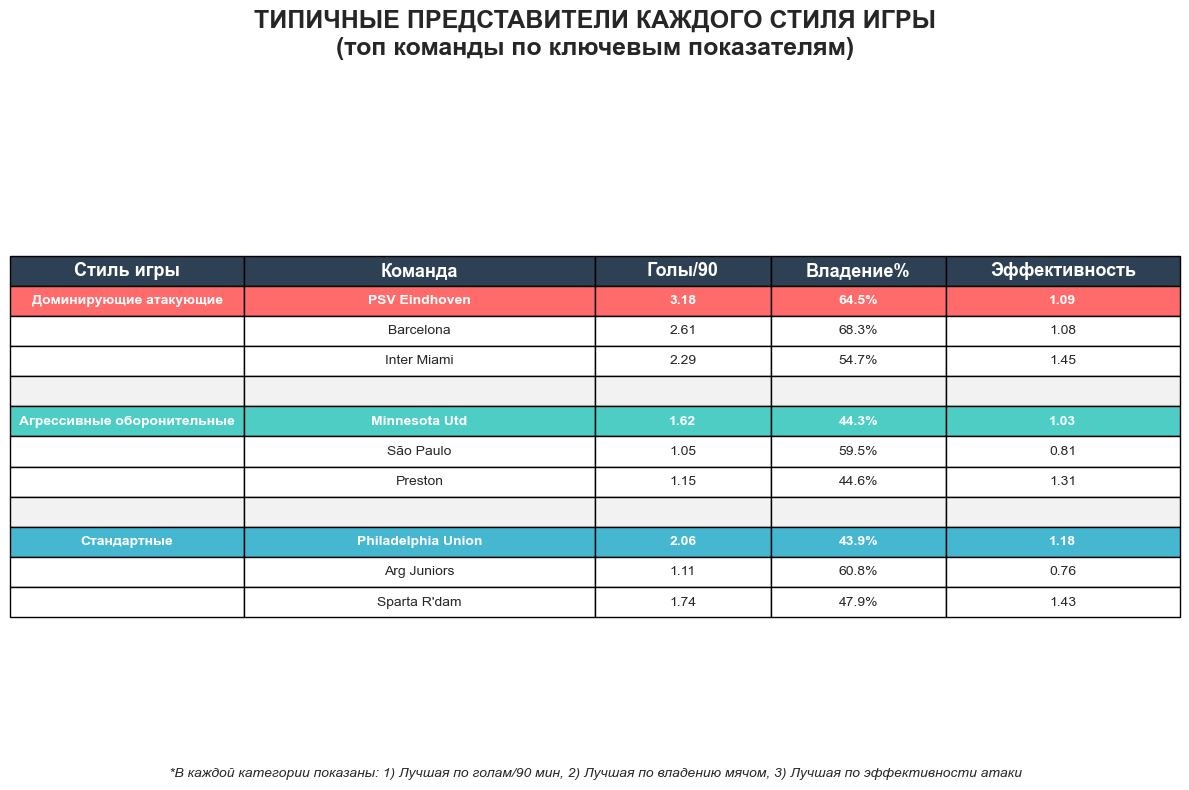

✅ Сохранено: result_3_typical_teams_table.png


In [277]:
print("\n" + "=" * 80)
print("🏆 ИНФОГРАФИКА 3: ТИПИЧНЫЕ ПРЕДСТАВИТЕЛИ СТИЛЕЙ")
print("=" * 80)

fig3, ax3 = plt.subplots(figsize=(12, 8))
ax3.axis('tight')
ax3.axis('off')

# Собираем данные для таблицы
table_data = []

# Получаем названия стилей
if 'cluster_names' not in locals():
    # Создаем имена стилей если их нет
    cluster_names = []
    for cluster_id in range(3):
        cluster_data = clustering_data_clean[clustering_data_clean['cluster'] == cluster_id]
        avg_goals = cluster_data['goals_per_90'].mean()
        avg_possession = cluster_data['possession_pct'].mean()
        
        if avg_goals > 1.4:
            if avg_possession > 52:
                style_name = "Доминирующие атакующие"
            else:
                style_name = "Эффективные контратакующие"
        elif avg_goals < 1.2:
            style_name = "Оборонительные"
        else:
            style_name = "Сбалансированные"
        
        cluster_names.append(style_name)

# Собираем топ команды для каждого стиля
for cluster_id in range(3):
    cluster_teams = clustering_data_clean[clustering_data_clean['cluster'] == cluster_id]
    
    if len(cluster_teams) > 0:
        # Топ команда по голам
        top_by_goals = cluster_teams.nlargest(1, 'goals_per_90').iloc[0]
        
        # Топ команда по владению
        top_by_possession = cluster_teams.nlargest(1, 'possession_pct').iloc[0]
        
        # Топ команда по эффективности
        top_by_efficiency = cluster_teams.nlargest(1, 'attack_efficiency').iloc[0]
        
        table_data.append([
            cluster_names[cluster_id],
            f"{top_by_goals['team_name'][:20]}",
            f"{top_by_goals['goals_per_90']:.2f}",
            f"{top_by_goals['possession_pct']:.1f}%",
            f"{top_by_goals['attack_efficiency']:.2f}"
        ])
        
        table_data.append([
            "",
            f"{top_by_possession['team_name'][:20]}",
            f"{top_by_possession['goals_per_90']:.2f}",
            f"{top_by_possession['possession_pct']:.1f}%",
            f"{top_by_possession['attack_efficiency']:.2f}"
        ])
        
        table_data.append([
            "",
            f"{top_by_efficiency['team_name'][:20]}",
            f"{top_by_efficiency['goals_per_90']:.2f}",
            f"{top_by_efficiency['possession_pct']:.1f}%",
            f"{top_by_efficiency['attack_efficiency']:.2f}"
        ])
        
        # Добавляем разделитель между стилями
        if cluster_id < 2:
            table_data.append(["─"*20, "─"*20, "─"*10, "─"*10, "─"*10])

# Создаем таблицу
table = ax3.table(
    cellText=table_data,
    colLabels=['Стиль игры', 'Команда', 'Голы/90', 'Владение%', 'Эффективность'],
    cellLoc='center',
    loc='center',
    colWidths=[0.2, 0.3, 0.15, 0.15, 0.2]
)

# Настраиваем стиль таблицы
table.auto_set_font_size(False)
table.set_fontsize(10)

# Увеличиваем высоту строк
table.scale(1, 1.8)

# Стилизуем заголовки
for i in range(5):
    table[(0, i)].set_facecolor('#2E4053')
    table[(0, i)].set_text_props(weight='bold', color='white', size=13)

# Стилизуем строки с названиями стилей
for i in range(len(table_data)):
    if table_data[i][0] and table_data[i][0] != "─"*20:  # Если это строка с названием стиля
        for j in range(5):
            table[(i+1, j)].set_facecolor(colors[cluster_names.index(table_data[i][0])])
            table[(i+1, j)].set_text_props(weight='bold', color='white')

# Стилизуем разделители
for i in range(len(table_data)):
    if table_data[i][0] == "─"*20:  # Если это разделитель
        for j in range(5):
            table[(i+1, j)].set_facecolor('#F2F2F2')
            table[(i+1, j)].set_text_props(color='#F2F2F2')

# Заголовок
ax3.set_title('ТИПИЧНЫЕ ПРЕДСТАВИТЕЛИ КАЖДОГО СТИЛЯ ИГРЫ\n(топ команды по ключевым показателям)', 
              fontsize=18, fontweight='bold', pad=30, y=1.05)

# Подпись
ax3.text(0.5, -0.05, 
        '*В каждой категории показаны: 1) Лучшая по голам/90 мин, 2) Лучшая по владению мячом, 3) Лучшая по эффективности атаки',
        transform=ax3.transAxes, ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('result_3_typical_teams_table.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Сохранено: result_3_typical_teams_table.png")